## Setup - imports, time, parameters, size function

In [1]:
runno = '7490'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

725015

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

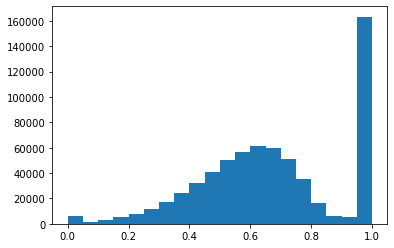

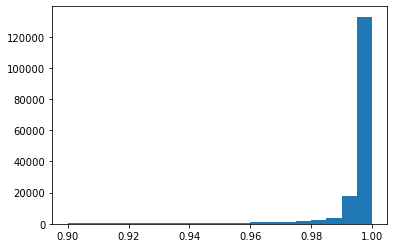

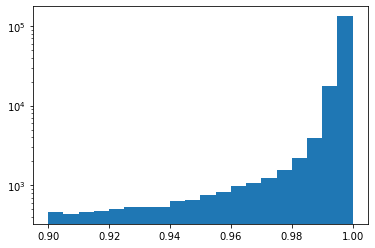

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

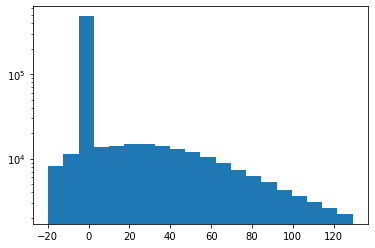

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

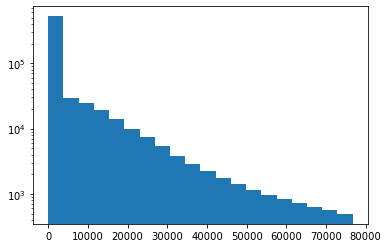

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = 4517.1 , 9995.8
Selected percentage = 10.7 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 19.5
200000 / 612184
Est remaining = 15.4
300000 / 612184
Est remaining = 11.8
400000 / 612184
Est remaining = 8.7
500000 / 612184
Est remaining = 4.9
600000 / 612184
Est remaining = 0.5


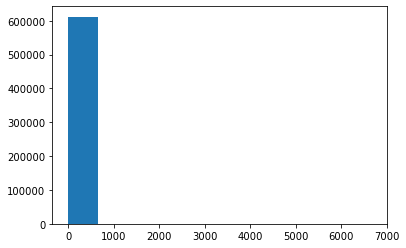

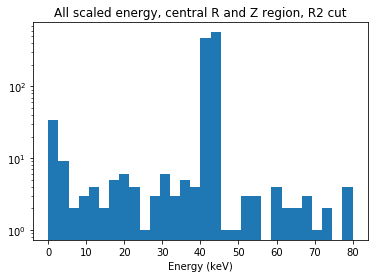

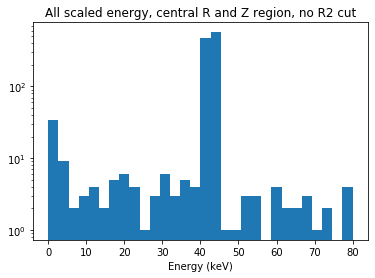

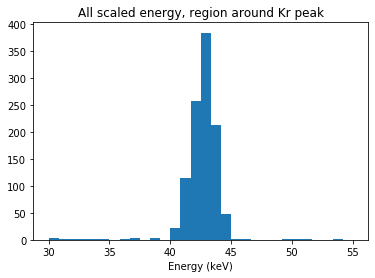

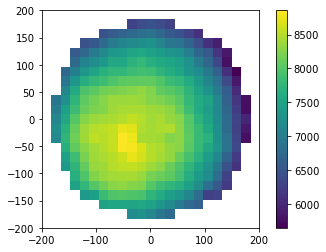

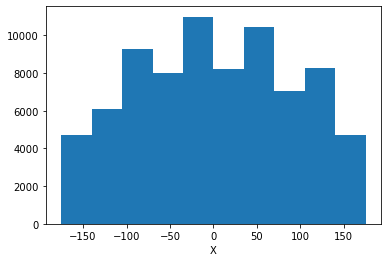

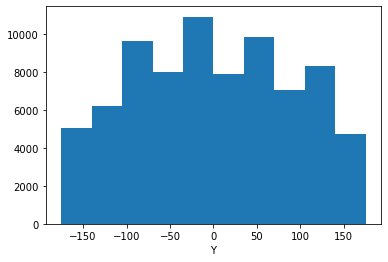

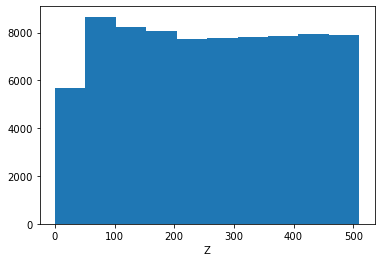

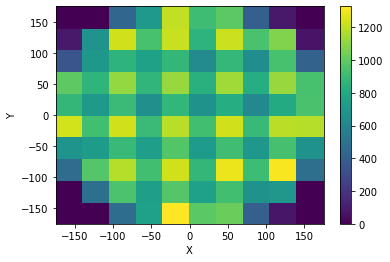

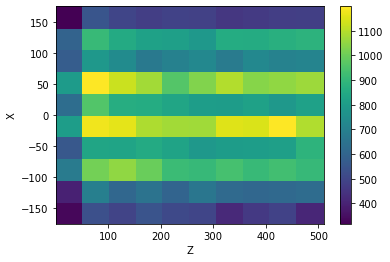

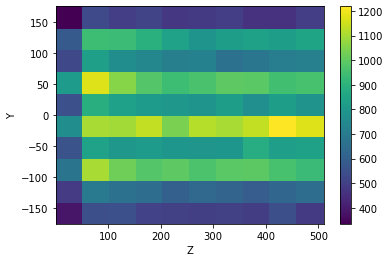

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = 3825.5 , 10078.9
Selected percentage = 10.8 \%


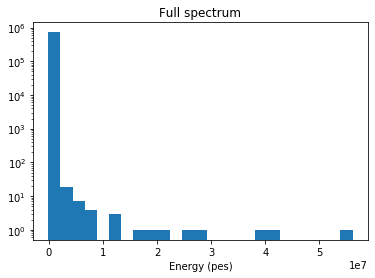

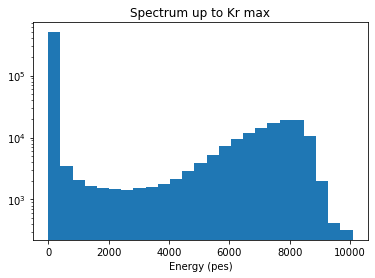

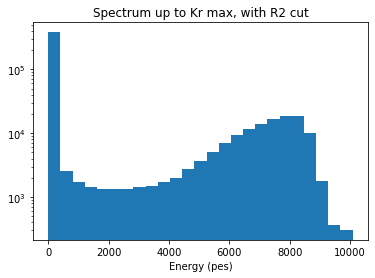

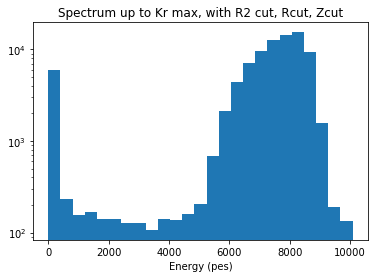

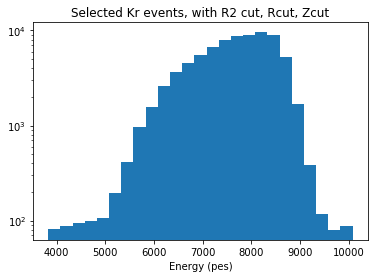

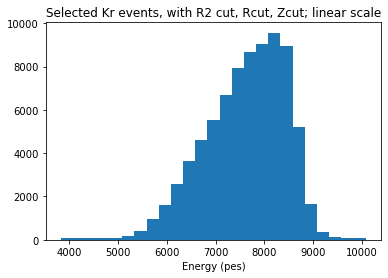

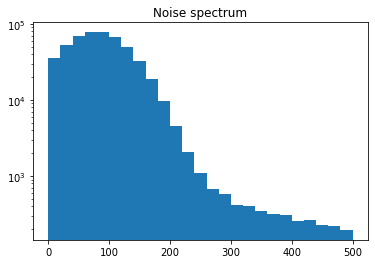

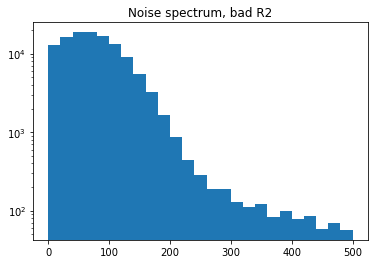

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


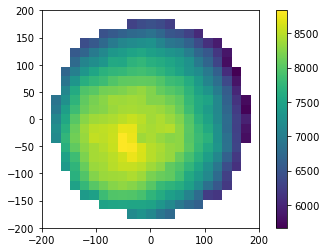

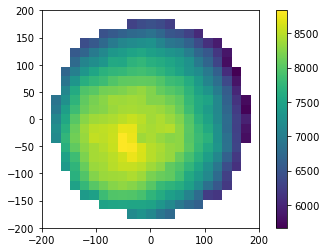

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 19.0
200000 / 612184
Est remaining = 15.2
300000 / 612184
Est remaining = 11.5
400000 / 612184
Est remaining = 7.8
500000 / 612184
Est remaining = 4.2
600000 / 612184
Est remaining = 0.5


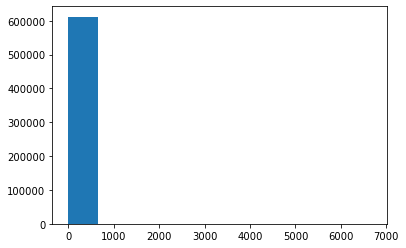

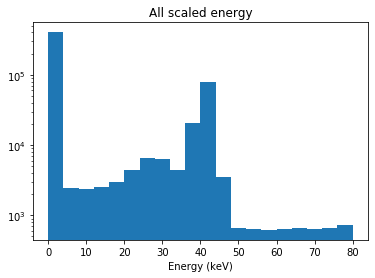

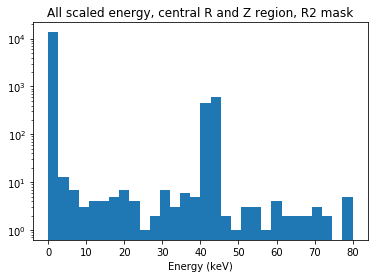

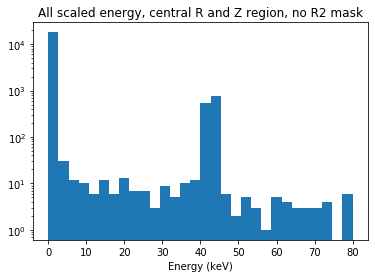

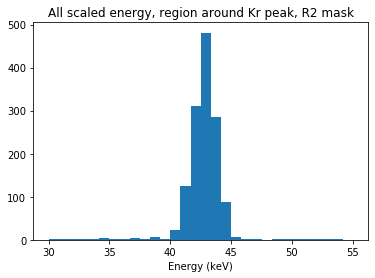

Correcting energies...
0 / 78406


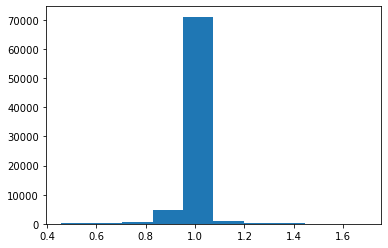

Fit a Gaussian with guess (A0, m0, s0) = (200.0, 1, 0.059912198796692566)


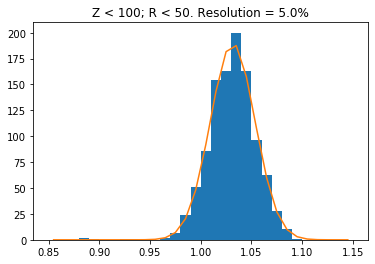

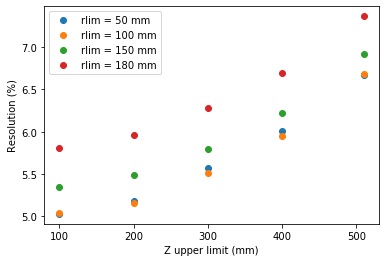

Innermost resolution =  5.03 %
Outermost resolution =  7.37 %
All resolutions: {100050: 5.0253341991690865, 100100: 5.03313508518825, 100150: 5.3471660837671955, 100180: 5.803930394692089, 200050: 5.178309190457525, 200100: 5.156959588908664, 200150: 5.488932259757698, 200180: 5.962850677316109, 300050: 5.5653084233736685, 300100: 5.5131060128553315, 300150: 5.793454852309266, 300180: 6.275254864059031, 400050: 6.002482237932489, 400100: 5.950928799564196, 400150: 6.22530138485643, 400180: 6.699055281040685, 510050: 6.671392822998428, 510100: 6.681891800692839, 510150: 6.916719841684715, 510180: 7.368100464755052}

================ CHECKING R2 CUT = 0.5 ================
Peak range = 3945.0 , 10068.9
Selected percentage = 10.8 \%


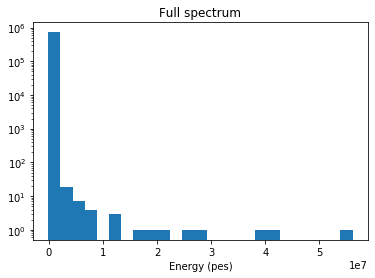

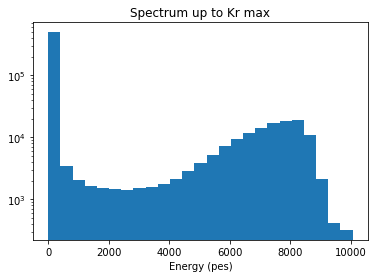

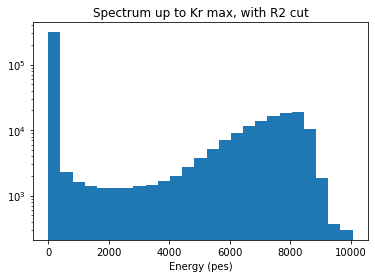

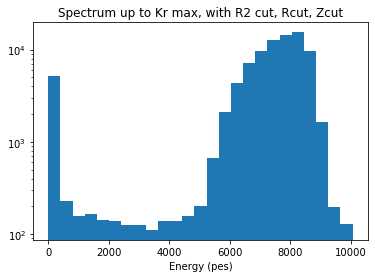

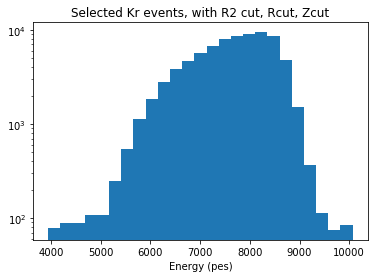

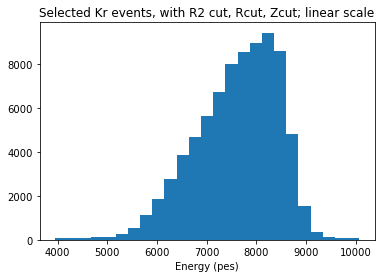

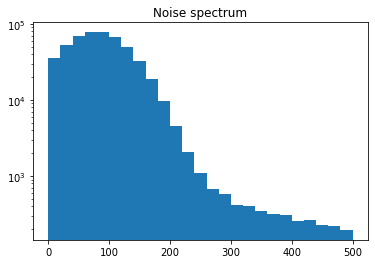

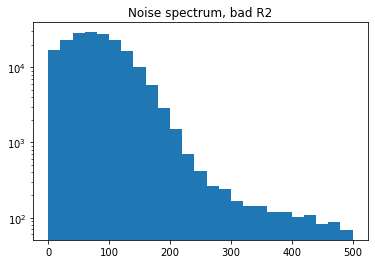

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


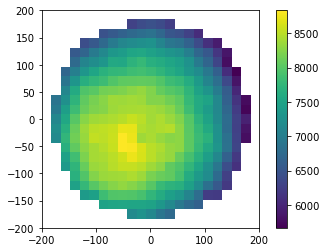

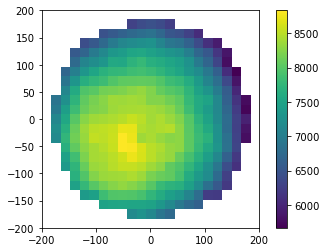

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 20.2
200000 / 612184
Est remaining = 18.3
300000 / 612184
Est remaining = 13.5
400000 / 612184
Est remaining = 8.9
500000 / 612184
Est remaining = 4.6
600000 / 612184
Est remaining = 0.5


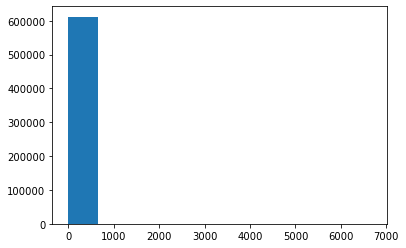

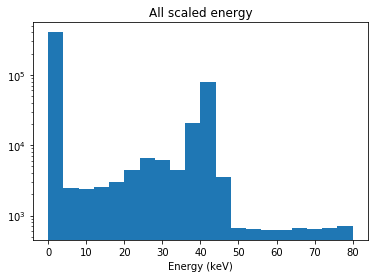

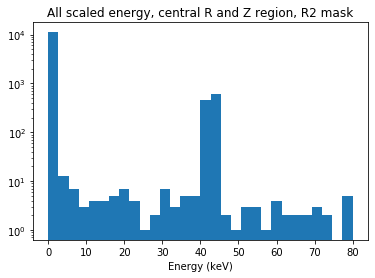

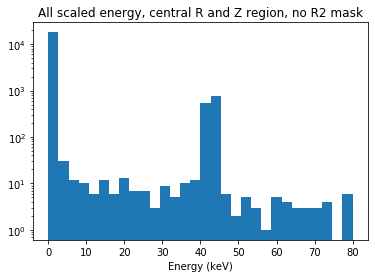

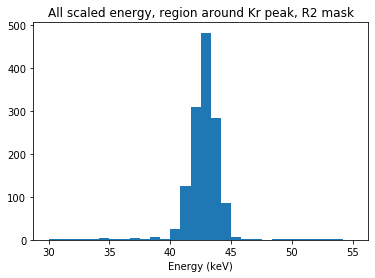

Correcting energies...
0 / 78350


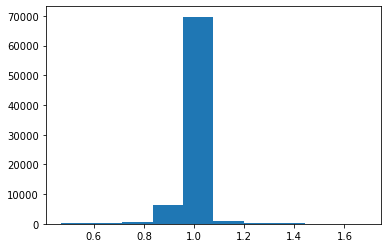

Fit a Gaussian with guess (A0, m0, s0) = (200.0, 1, 0.05738698698976831)


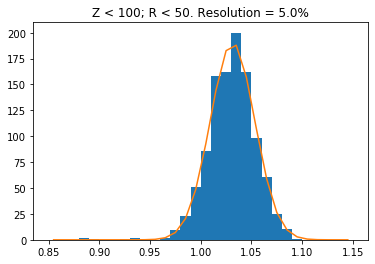

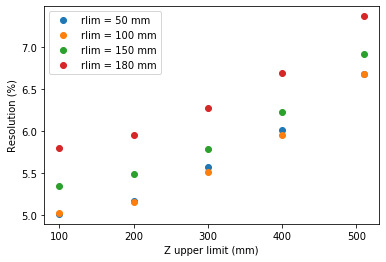

Innermost resolution =  5.01 %
Outermost resolution =  7.37 %
All resolutions: {100050: 5.0112656147319035, 100100: 5.021285727059369, 100150: 5.340662904855202, 100180: 5.795026482804168, 200050: 5.160972668222838, 200100: 5.149172310653246, 200150: 5.483006093973834, 200180: 5.955623112640559, 300050: 5.56532933125887, 300100: 5.506124657840499, 300150: 5.7864490166482945, 300180: 6.269546840155781, 400050: 6.013891409450232, 400100: 5.94970655529179, 400150: 6.222503552643695, 400180: 6.695705913579626, 510050: 6.679391391904163, 510100: 6.679949603304962, 510150: 6.91817391759546, 510180: 7.366600907730827}

================ CHECKING R2 CUT = 0.6 ================
Peak range = 4116.8 , 10051.4
Selected percentage = 10.8 \%


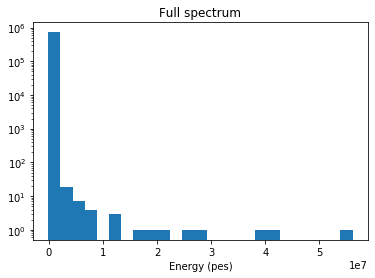

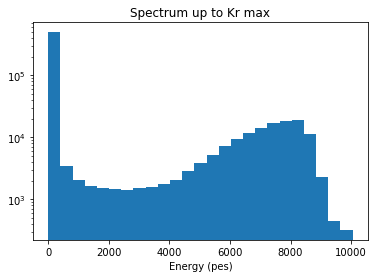

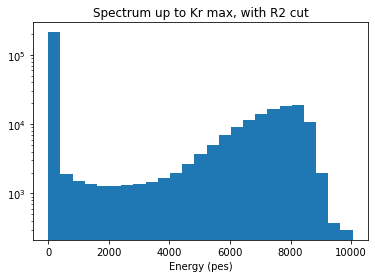

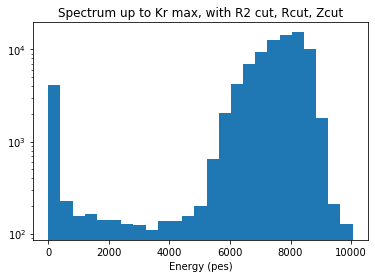

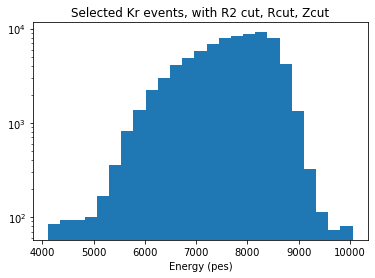

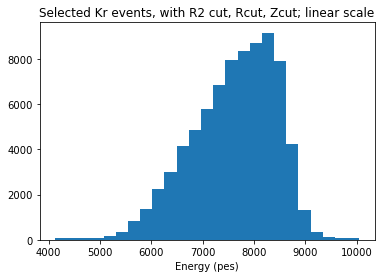

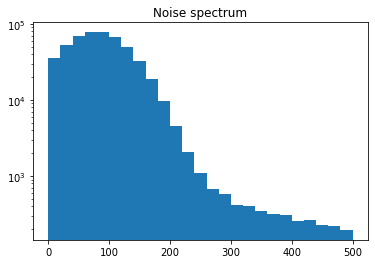

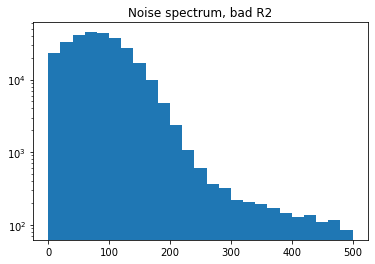

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


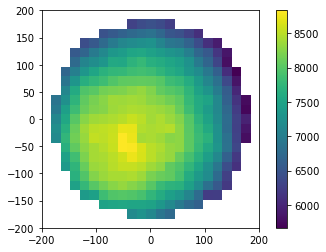

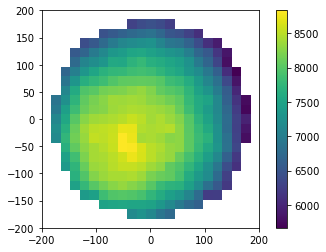

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 38.3
200000 / 612184
Est remaining = 29.4
300000 / 612184
Est remaining = 20.2
400000 / 612184
Est remaining = 13.5
500000 / 612184
Est remaining = 6.7
600000 / 612184
Est remaining = 0.7


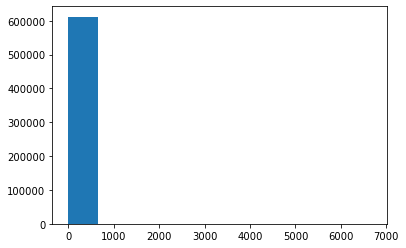

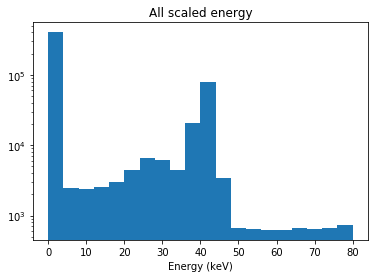

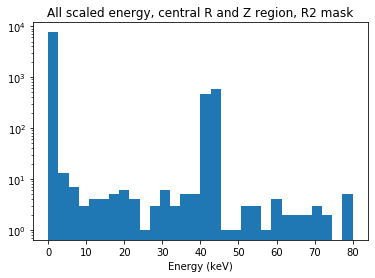

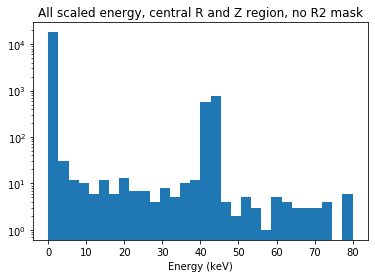

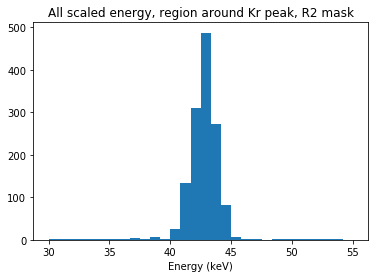

Correcting energies...
0 / 78288


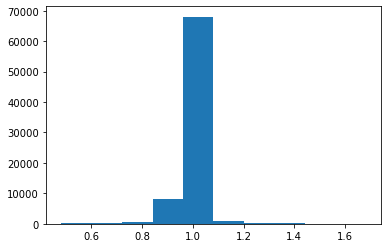

Fit a Gaussian with guess (A0, m0, s0) = (200.0, 1, 0.04983925399309522)


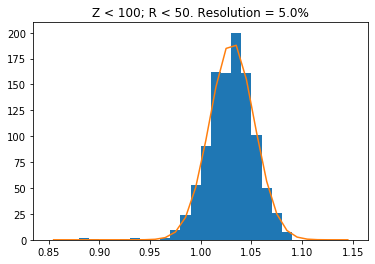

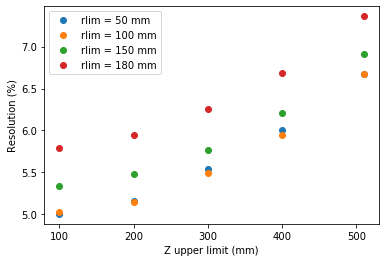

Innermost resolution =  5.01 %
Outermost resolution =  7.36 %
All resolutions: {100050: 5.006100393362716, 100100: 5.027447640924266, 100150: 5.336245607331592, 100180: 5.787393950232707, 200050: 5.154844790139098, 200100: 5.153450960721441, 200150: 5.47753499265419, 200180: 5.949423636924618, 300050: 5.541836897859891, 300100: 5.49646246818908, 300150: 5.7732052109735275, 300180: 6.256422863280967, 400050: 6.001964713248857, 400100: 5.940695184175499, 400150: 6.213551696293155, 400180: 6.68682444369059, 510050: 6.672533675890615, 510100: 6.675331629514996, 510150: 6.913514947924757, 510180: 7.360754104250033}

================ CHECKING R2 CUT = 0.7 ================
Peak range = 4285.8 , 10028.3
Selected percentage = 10.8 \%


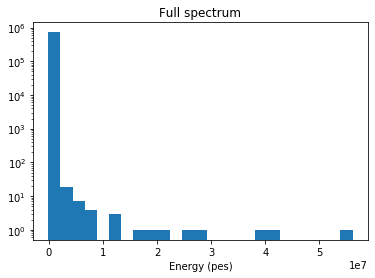

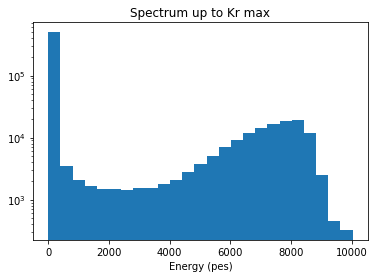

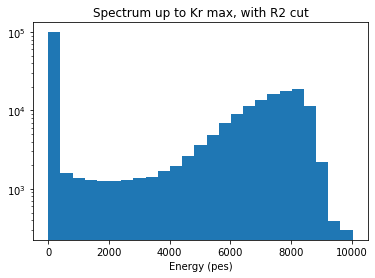

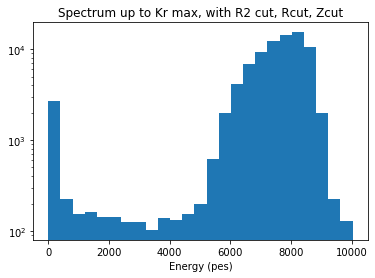

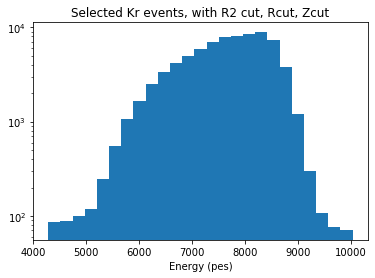

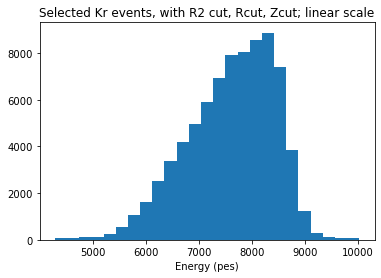

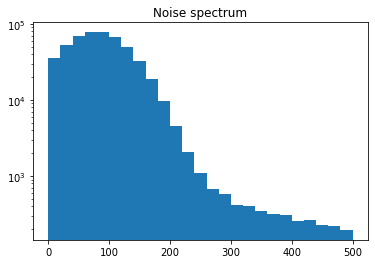

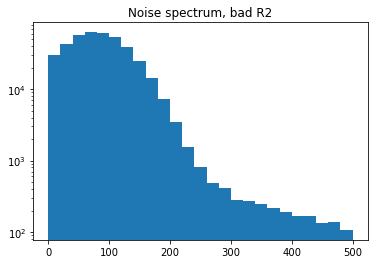

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


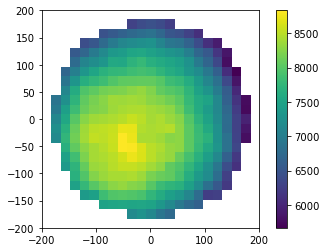

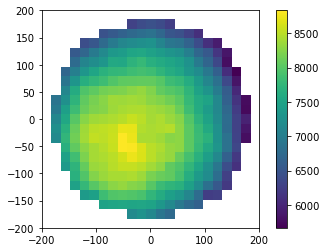

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 26.7
200000 / 612184
Est remaining = 20.9
300000 / 612184
Est remaining = 16.5
400000 / 612184
Est remaining = 10.6
500000 / 612184
Est remaining = 5.6
600000 / 612184
Est remaining = 0.6


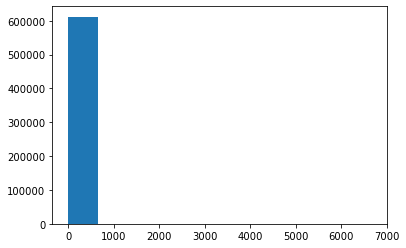

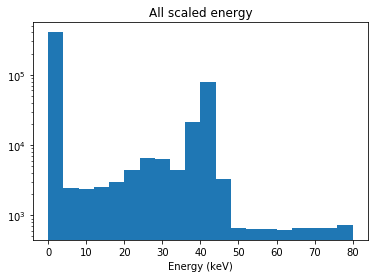

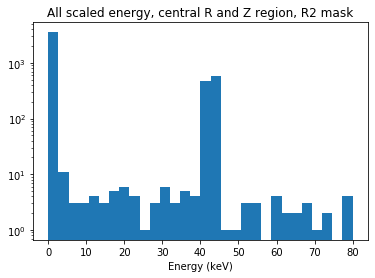

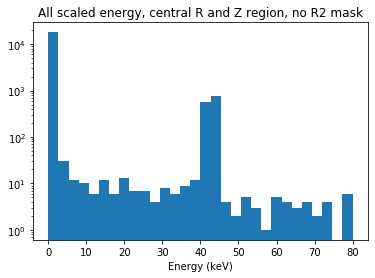

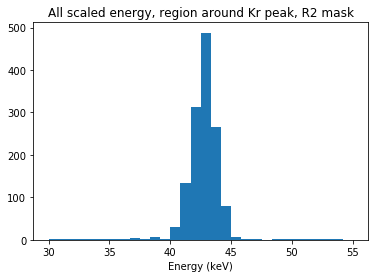

Correcting energies...
0 / 78194


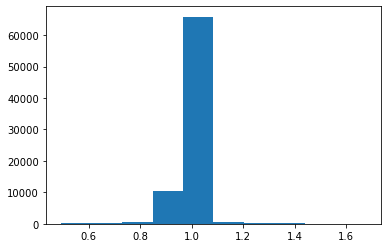

Fit a Gaussian with guess (A0, m0, s0) = (197.0, 1, 0.04982080896058916)


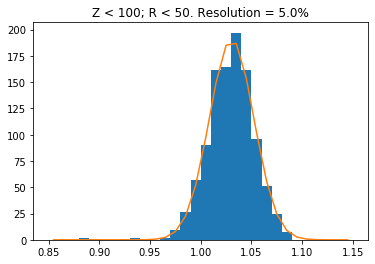

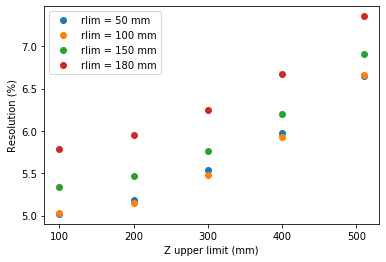

Innermost resolution =  5.02 %
Outermost resolution =  7.36 %
All resolutions: {100050: 5.019053338107331, 100100: 5.032193281190314, 100150: 5.331645159370152, 100180: 5.786309583668666, 200050: 5.178189875557655, 200100: 5.15006706540562, 200150: 5.472336504404357, 200180: 5.946315127378704, 300050: 5.537782270253458, 300100: 5.481841630296413, 300150: 5.762871910518926, 300180: 6.248169980962064, 400050: 5.980792320471419, 400100: 5.926612804640699, 400150: 6.202315644178806, 400180: 6.677501076508207, 510050: 6.65402963791455, 510100: 6.664769271580304, 510150: 6.905618806915755, 510180: 7.356089703613145}

================ CHECKING R2 CUT = 0.8 ================
Peak range = 4455.9 , 10006.2
Selected percentage = 10.7 \%


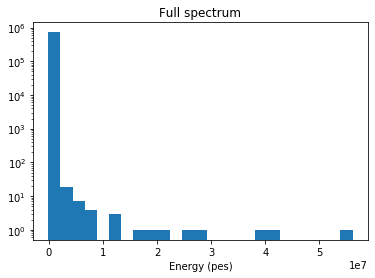

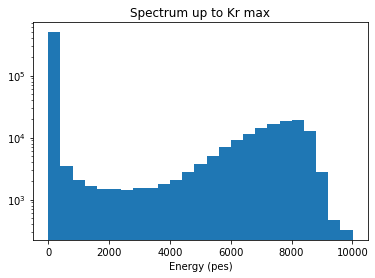

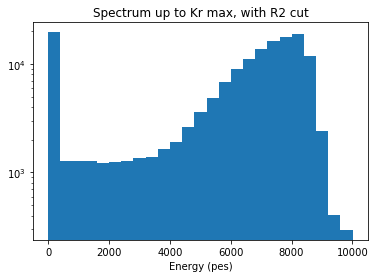

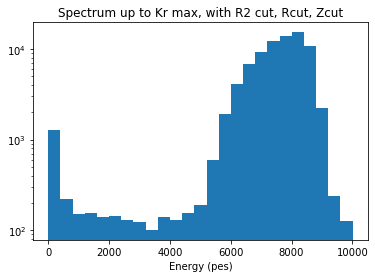

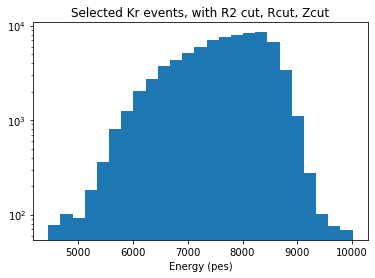

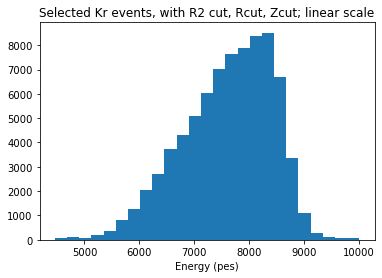

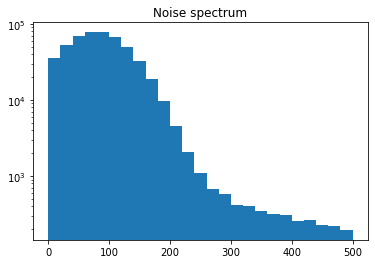

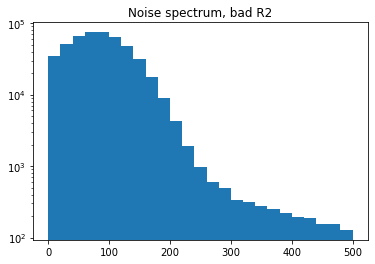

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


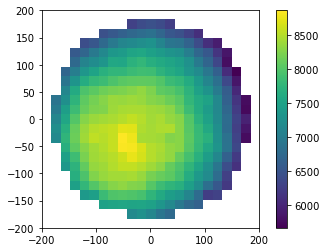

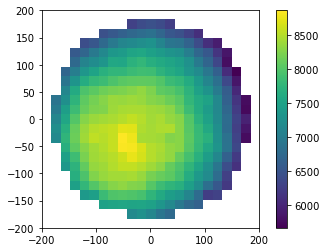

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 22.2
200000 / 612184
Est remaining = 17.5
300000 / 612184
Est remaining = 14.2
400000 / 612184
Est remaining = 9.6
500000 / 612184
Est remaining = 5.1
600000 / 612184
Est remaining = 0.5


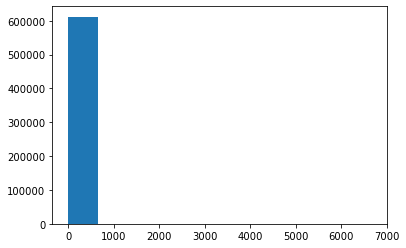

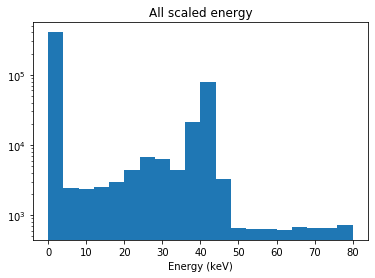

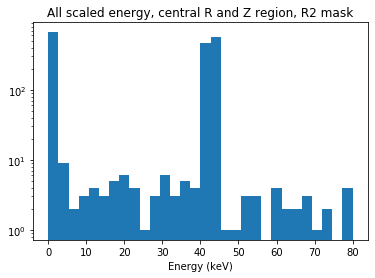

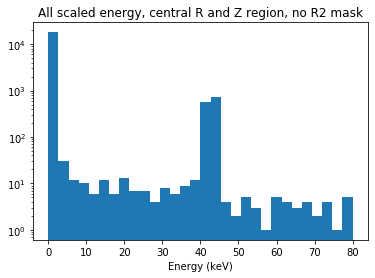

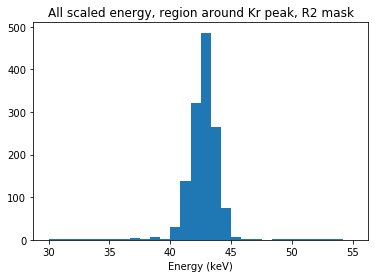

Correcting energies...
0 / 77886


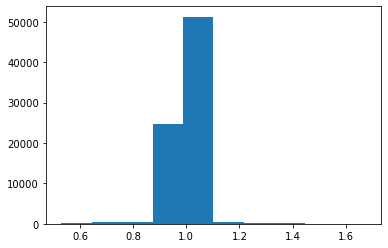

Fit a Gaussian with guess (A0, m0, s0) = (191.0, 1, 0.045224761663551626)


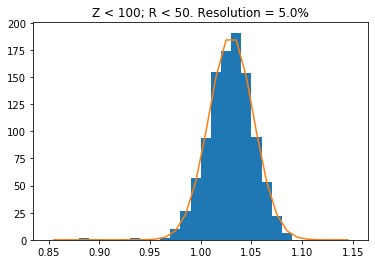

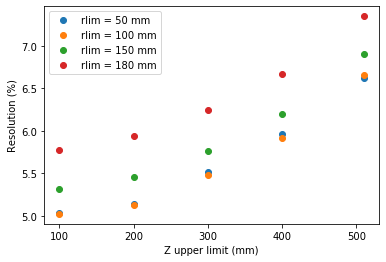

Innermost resolution =  5.03 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.0286770402779, 100100: 5.022206773126058, 100150: 5.320327850698375, 100180: 5.779512252384784, 200050: 5.1354432938511145, 200100: 5.131854029101257, 200150: 5.460030277305863, 200180: 5.9389207483305615, 300050: 5.51524605833408, 300100: 5.4796208003134455, 300150: 5.767106953031478, 300180: 6.2484174241896735, 400050: 5.958964108591497, 400100: 5.921933676920528, 400150: 6.202431306699987, 400180: 6.673198731563892, 510050: 6.628031346981733, 510100: 6.6570573346068, 510150: 6.904308514583851, 510180: 7.351115167885624}

================ CHECKING R2 CUT = 0.9 ================
Peak range = 4533.8 , 9993.7
Selected percentage = 10.7 \%


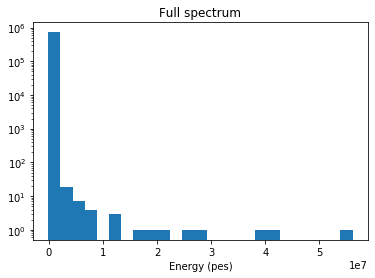

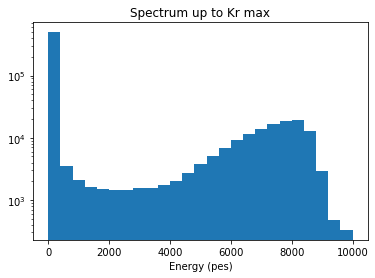

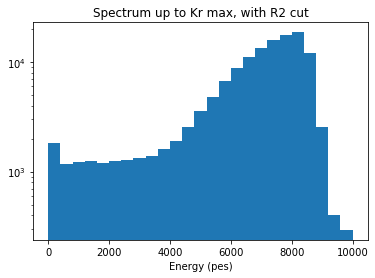

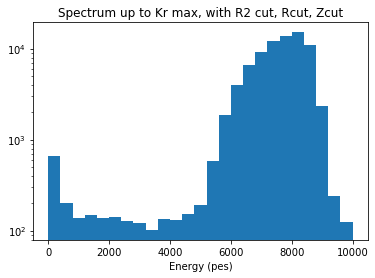

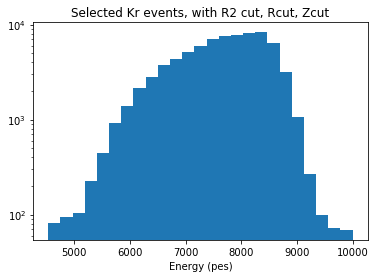

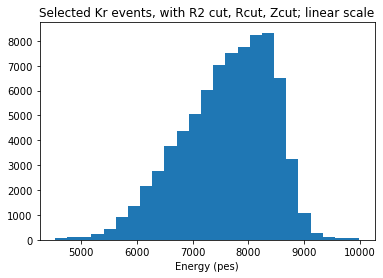

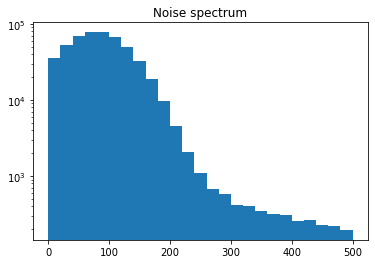

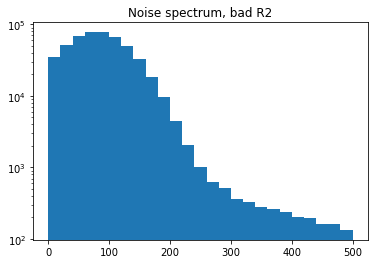

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


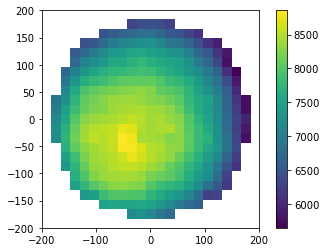

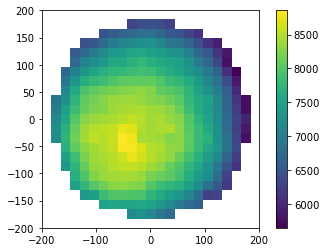

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 21.2
200000 / 612184
Est remaining = 20.5
300000 / 612184
Est remaining = 14.9
400000 / 612184
Est remaining = 9.8
500000 / 612184
Est remaining = 5.1
600000 / 612184
Est remaining = 0.6


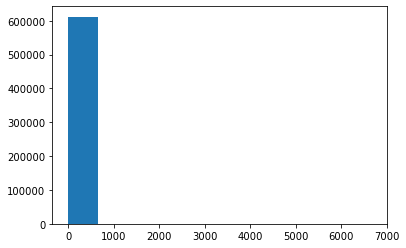

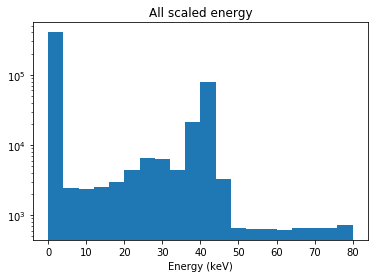

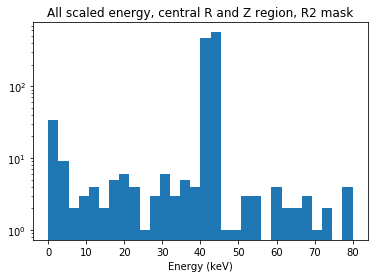

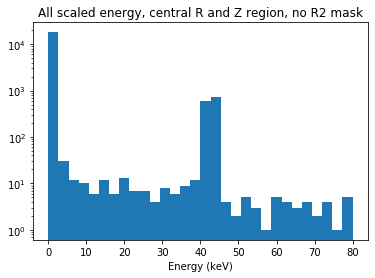

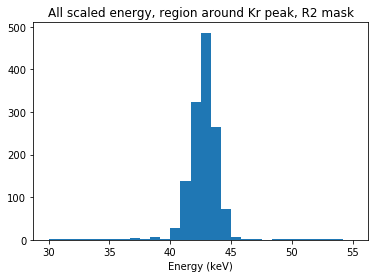

Correcting energies...
0 / 77634


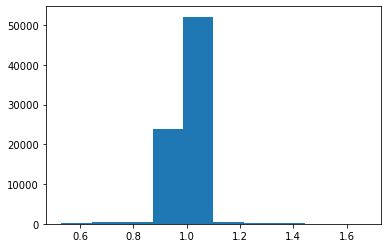

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.045269567741692544)


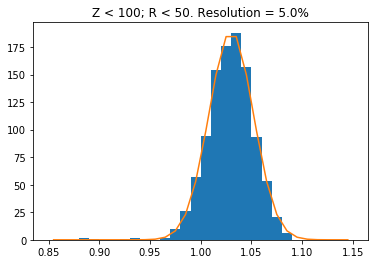

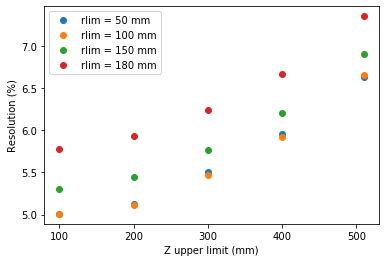

Innermost resolution =  5.01 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.0102724729160215, 100100: 5.007773020213628, 100150: 5.307614626399207, 100180: 5.774323749605739, 200050: 5.119923934861382, 200100: 5.112886298280806, 200150: 5.447667296889177, 200180: 5.928357881414043, 300050: 5.510015235164473, 300100: 5.47209728256366, 300150: 5.76373538952604, 300180: 6.245920302516311, 400050: 5.959735827169621, 400100: 5.916590857199791, 400150: 6.199962776871508, 400180: 6.673000148120859, 510050: 6.628381001108396, 510100: 6.655890472840465, 510150: 6.901548952455954, 510180: 7.352191828043946}

================ CHECKING R2 CUT = 0.92 ================
Peak range = 4543.6 , 9990.1
Selected percentage = 10.7 \%


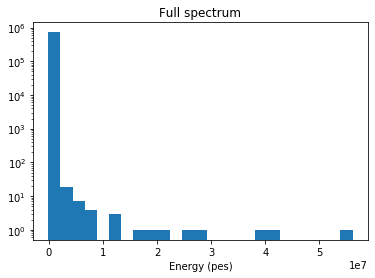

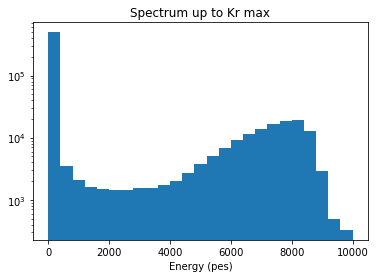

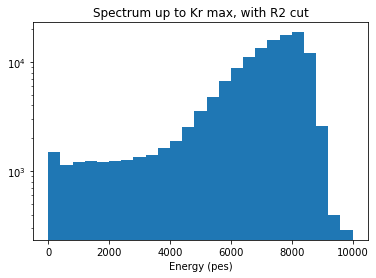

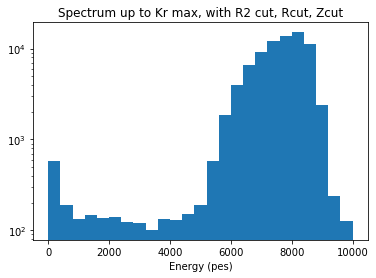

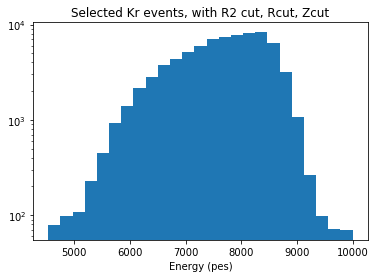

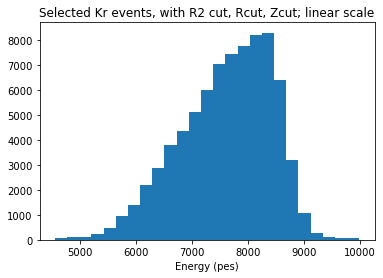

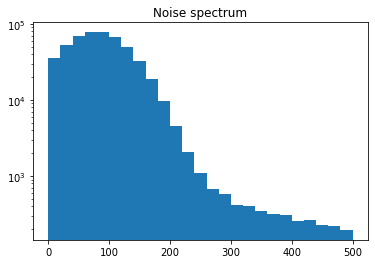

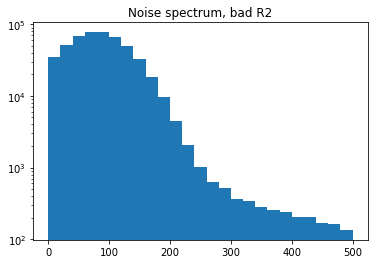

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


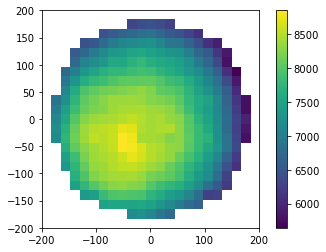

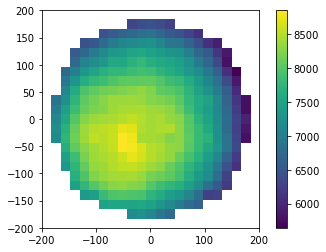

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 20.2
200000 / 612184
Est remaining = 17.7
300000 / 612184
Est remaining = 12.8
400000 / 612184
Est remaining = 8.3
500000 / 612184
Est remaining = 4.5
600000 / 612184
Est remaining = 0.5


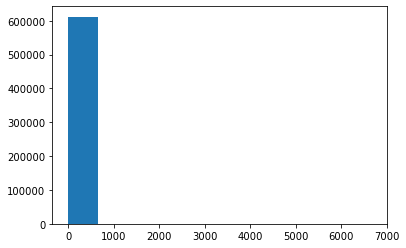

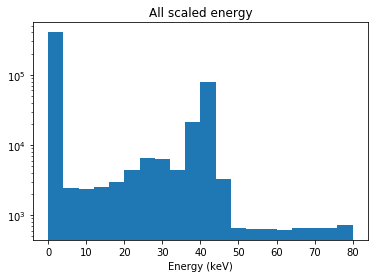

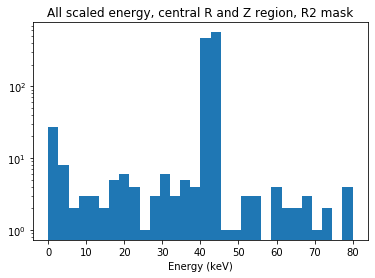

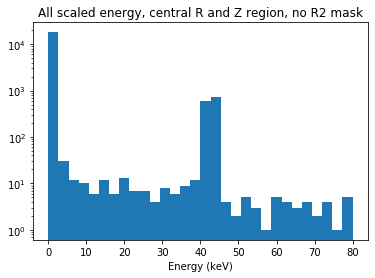

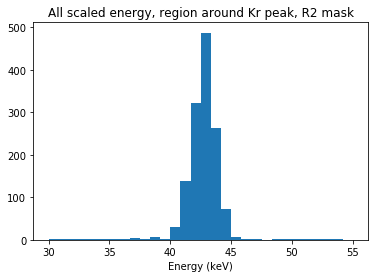

Correcting energies...
0 / 77570


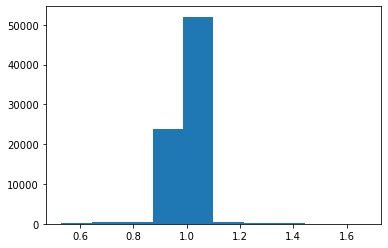

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.04528525510531514)


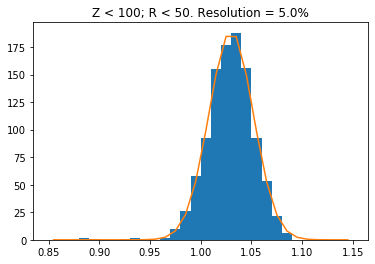

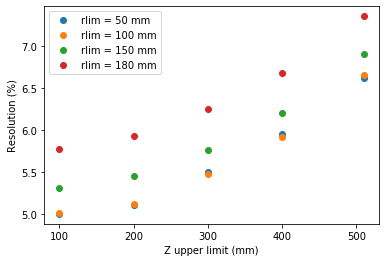

Innermost resolution =  5.0 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.001768933253929, 100100: 5.008215695498957, 100150: 5.308834743152305, 100180: 5.7771652431754985, 200050: 5.112962652367663, 200100: 5.117260729446649, 200150: 5.451378092990775, 200180: 5.930548308804199, 300050: 5.504860643827886, 300100: 5.474297561871355, 300150: 5.766406095175124, 300180: 6.2470600167612504, 400050: 5.953065464348038, 400100: 5.917287031681975, 400150: 6.200480860943467, 400180: 6.672233805370957, 510050: 6.618731724250012, 510100: 6.654546974124569, 510150: 6.900655159859345, 510180: 7.351168120091008}

================ CHECKING R2 CUT = 0.94 ================
Peak range = 4557.7 , 9987.9
Selected percentage = 10.7 \%


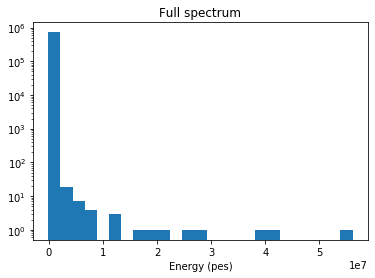

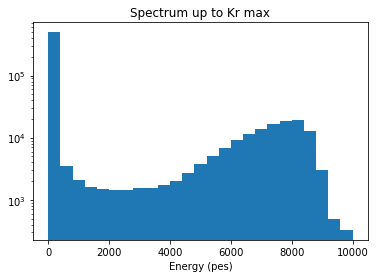

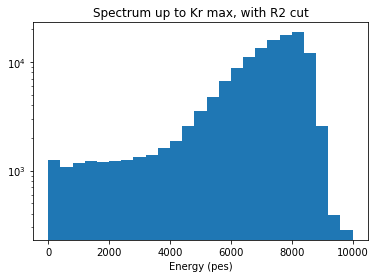

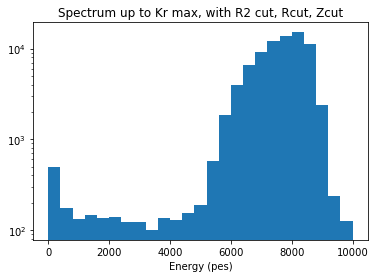

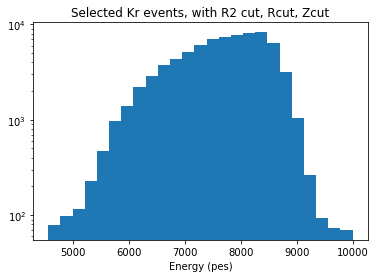

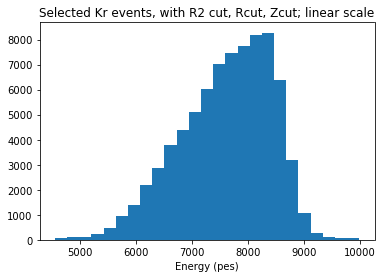

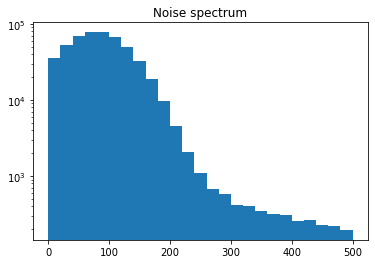

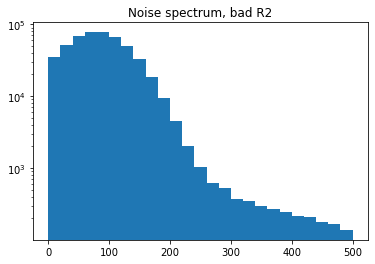

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


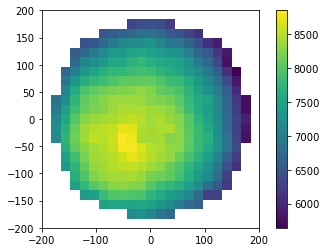

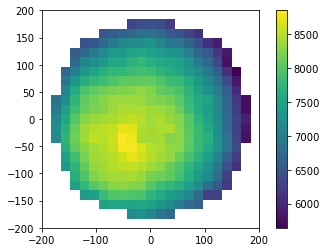

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 12.2
200000 / 612184
Est remaining = 9.6
300000 / 612184
Est remaining = 7.4
400000 / 612184
Est remaining = 5.0
500000 / 612184
Est remaining = 2.6
600000 / 612184
Est remaining = 0.3


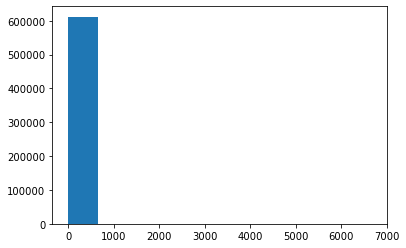

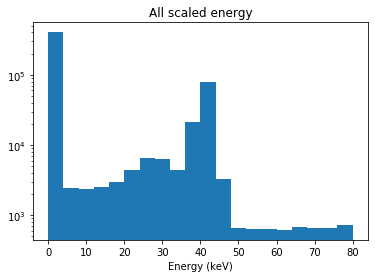

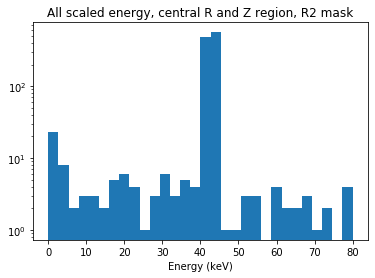

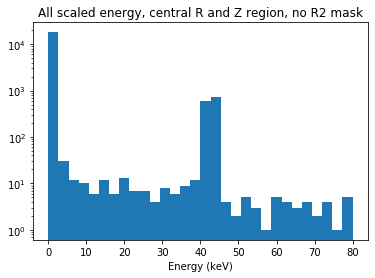

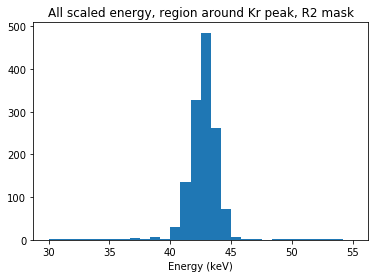

Correcting energies...
0 / 77484


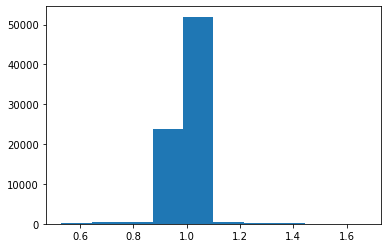

Fit a Gaussian with guess (A0, m0, s0) = (189.0, 1, 0.04531037319267316)


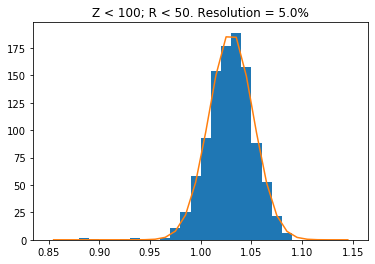

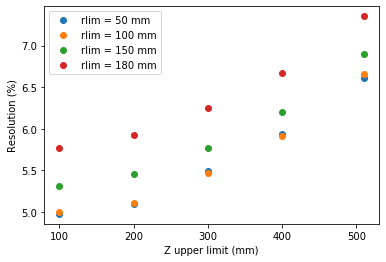

Innermost resolution =  4.98 %
Outermost resolution =  7.35 %
All resolutions: {100050: 4.975976704088314, 100100: 5.003912405784128, 100150: 5.30572131374756, 100180: 5.771222477795748, 200050: 5.092806623435025, 200100: 5.111909828702089, 200150: 5.450597727071486, 200180: 5.927781361326065, 300050: 5.490944027108364, 300100: 5.472299105586289, 300150: 5.767202629743668, 300180: 6.245448911219289, 400050: 5.941240694852534, 400100: 5.916515631964662, 400150: 6.203743272354162, 400180: 6.673087807373894, 510050: 6.607217557634971, 510100: 6.652569476910946, 510150: 6.903403118785296, 510180: 7.351963562993524}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 4576.5 , 9983.7
Selected percentage = 10.7 \%


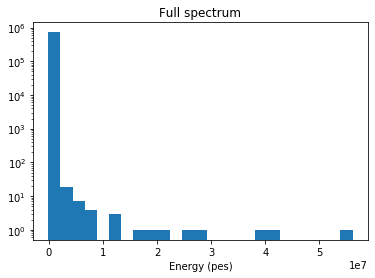

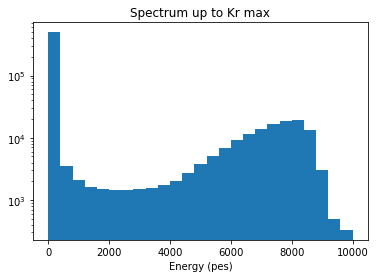

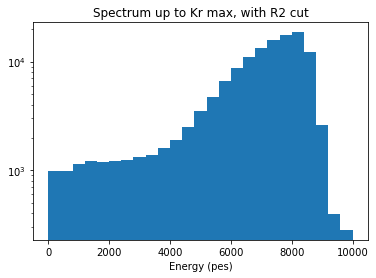

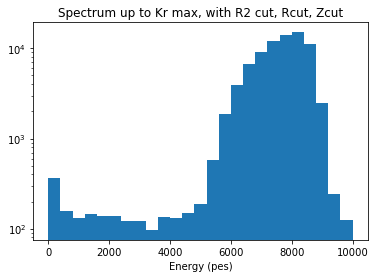

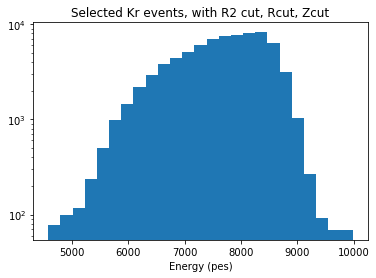

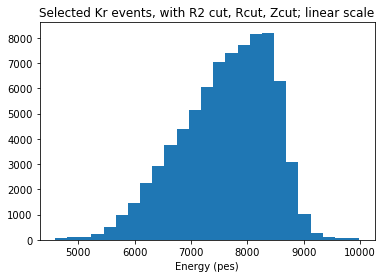

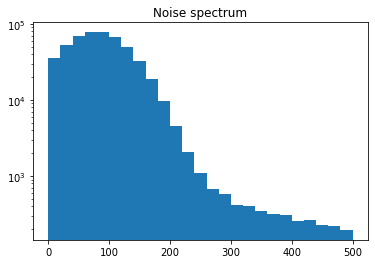

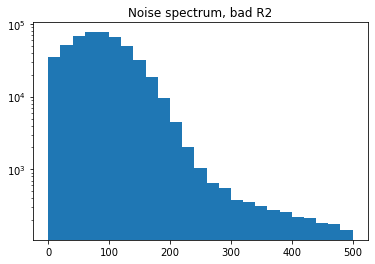

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


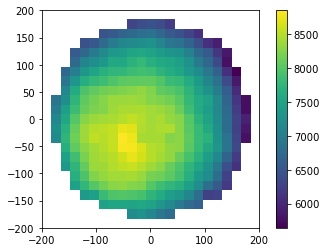

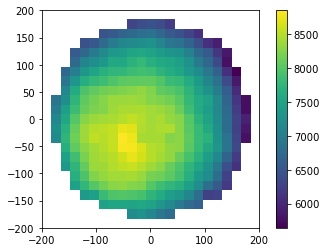

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 13.6
200000 / 612184
Est remaining = 10.4
300000 / 612184
Est remaining = 7.6
400000 / 612184
Est remaining = 5.1
500000 / 612184
Est remaining = 2.7
600000 / 612184
Est remaining = 0.3


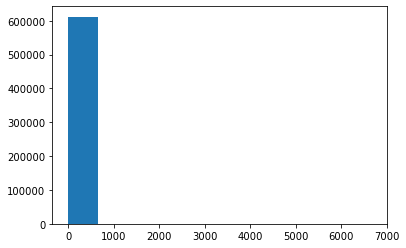

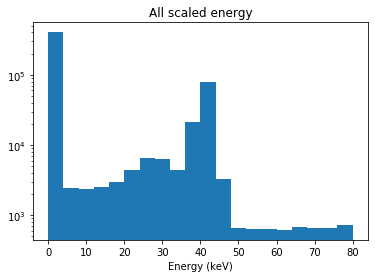

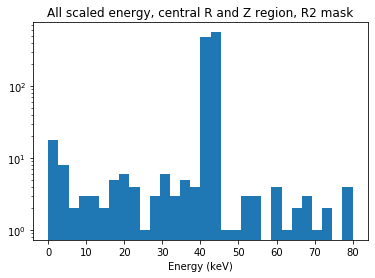

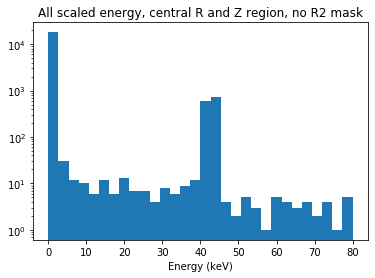

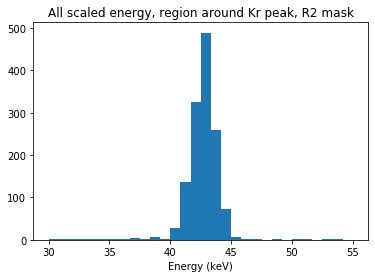

Correcting energies...
0 / 77365


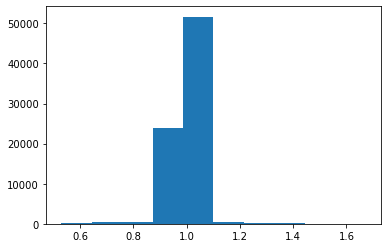

Fit a Gaussian with guess (A0, m0, s0) = (189.0, 1, 0.042535462676490346)


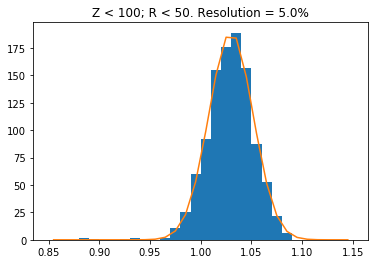

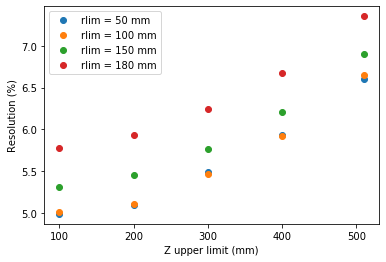

Innermost resolution =  4.99 %
Outermost resolution =  7.35 %
All resolutions: {100050: 4.987383260412532, 100100: 5.005787487122939, 100150: 5.309619077241936, 100180: 5.773630581734251, 200050: 5.090555973373163, 200100: 5.110287571227577, 200150: 5.451098869375834, 200180: 5.925727907308838, 300050: 5.489071207983603, 300100: 5.470883744273839, 300150: 5.766099872256232, 300180: 6.243642643168515, 400050: 5.936480762270792, 400100: 5.914777013354951, 400150: 6.204826473720871, 400180: 6.672306515382276, 510050: 6.606831457522213, 510100: 6.653509485742962, 510150: 6.905369023019027, 510180: 7.352709756946778}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 4595.8 , 9977.3
Selected percentage = 10.6 \%


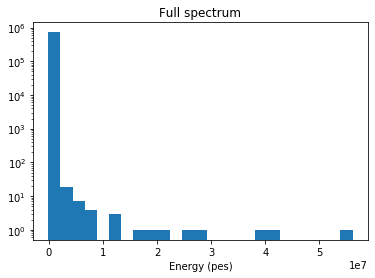

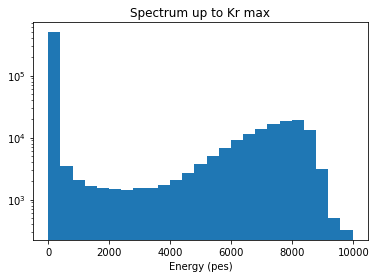

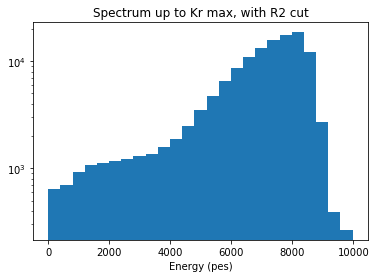

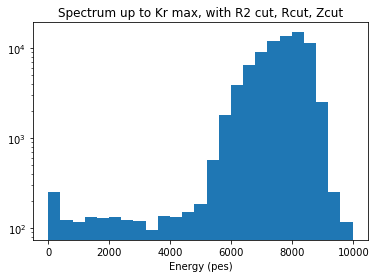

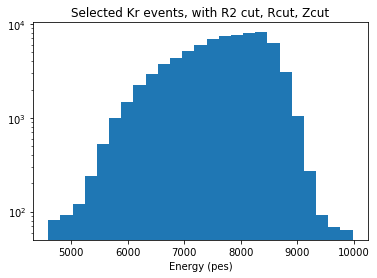

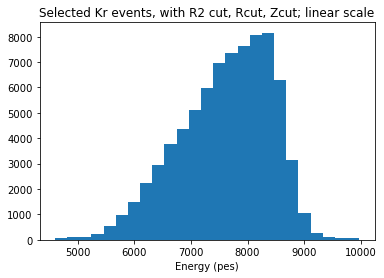

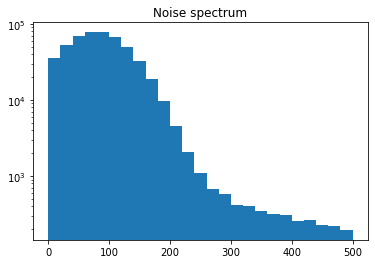

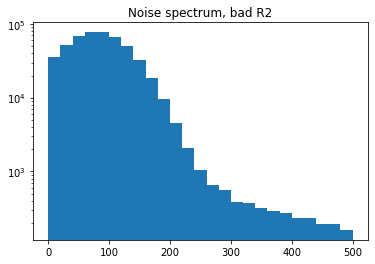

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


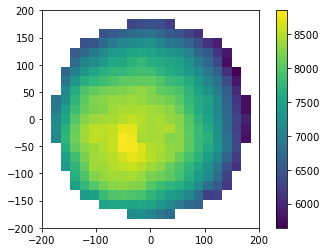

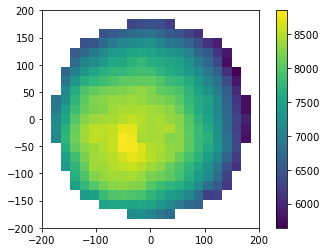

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 14.4
200000 / 612184
Est remaining = 10.6
300000 / 612184
Est remaining = 7.8
400000 / 612184
Est remaining = 5.2
500000 / 612184
Est remaining = 2.7
600000 / 612184
Est remaining = 0.3


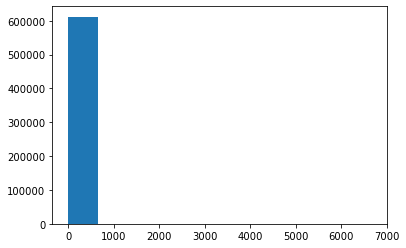

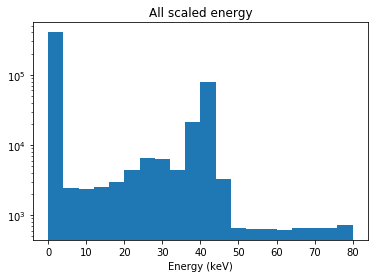

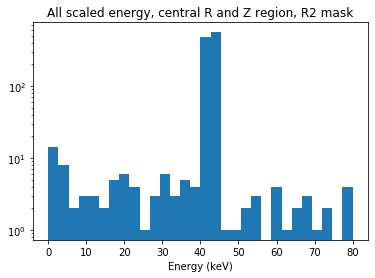

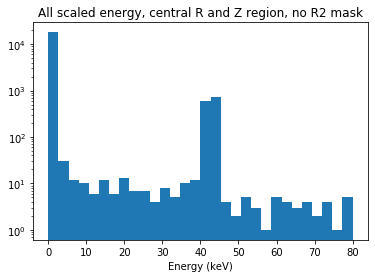

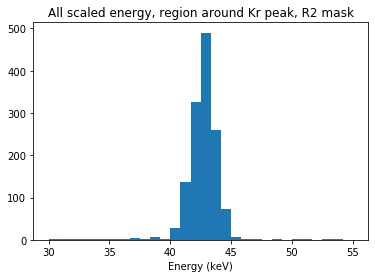

Correcting energies...
0 / 77111


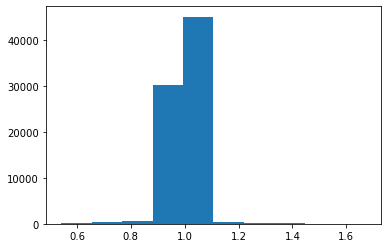

Fit a Gaussian with guess (A0, m0, s0) = (191.0, 1, 0.042564636043137705)


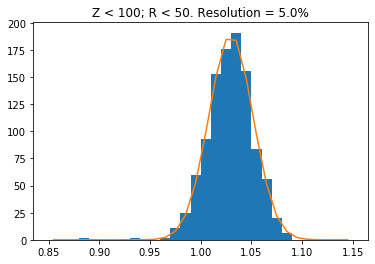

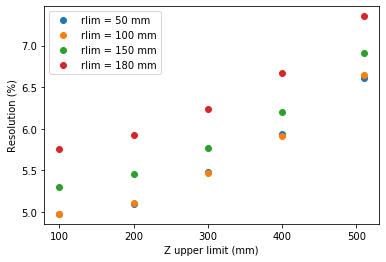

Innermost resolution =  4.98 %
Outermost resolution =  7.35 %
All resolutions: {100050: 4.976284503867006, 100100: 4.979156558601109, 100150: 5.300640728497208, 100180: 5.760088853369103, 200050: 5.095218657710392, 200100: 5.1036781473955175, 200150: 5.452911024742201, 200180: 5.922516118985895, 300050: 5.485393044635939, 300100: 5.468962150386127, 300150: 5.7682704734725165, 300180: 6.241619521804062, 400050: 5.93492323029676, 400100: 5.911649139281416, 400150: 6.203470441012553, 400180: 6.668182683055069, 510050: 6.612142396223783, 510100: 6.652001591782586, 510150: 6.907263935743625, 510180: 7.352662750104051}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 4627.5 , 9972.8
Selected percentage = 10.6 \%


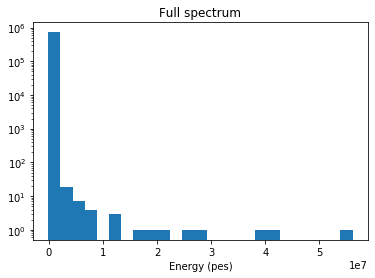

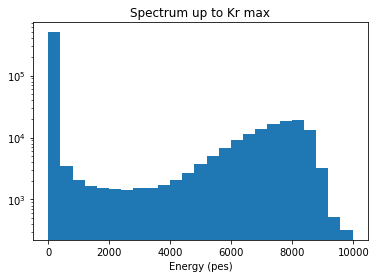

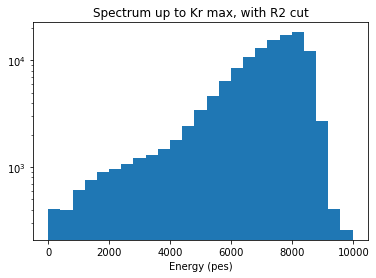

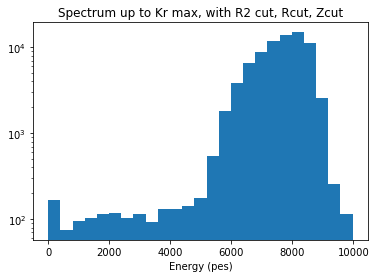

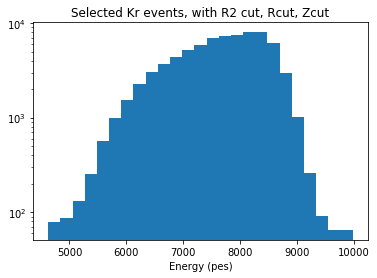

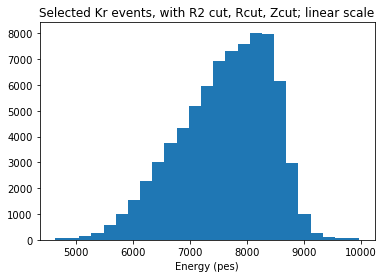

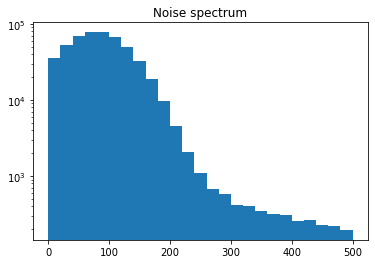

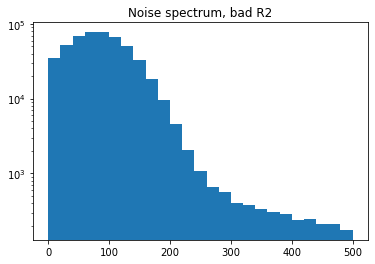

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


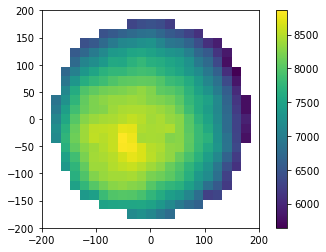

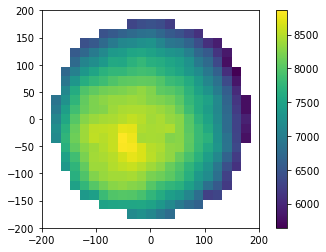

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 12.3
200000 / 612184
Est remaining = 10.3
300000 / 612184
Est remaining = 7.7
400000 / 612184
Est remaining = 5.2
500000 / 612184
Est remaining = 2.9
600000 / 612184
Est remaining = 0.3


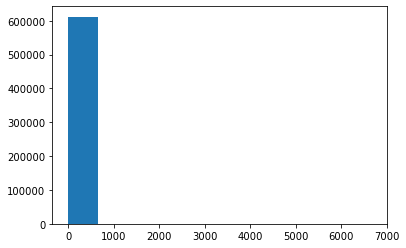

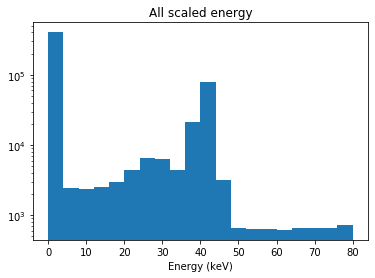

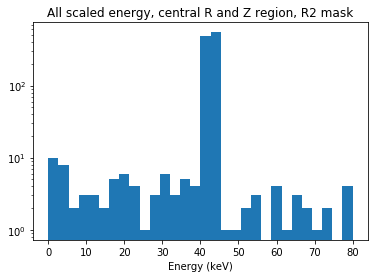

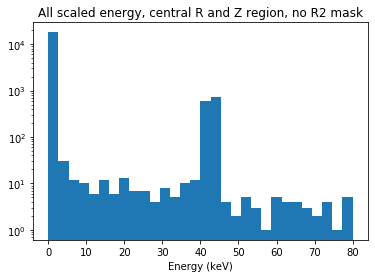

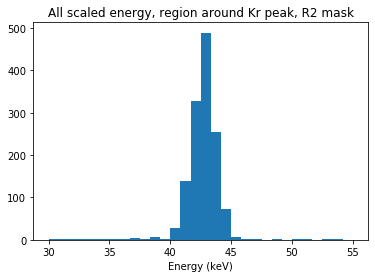

Correcting energies...
0 / 76534


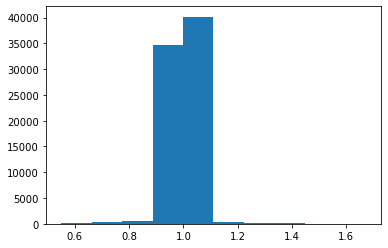

Fit a Gaussian with guess (A0, m0, s0) = (195.0, 1, 0.04266485644898396)


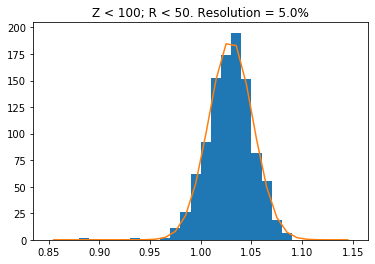

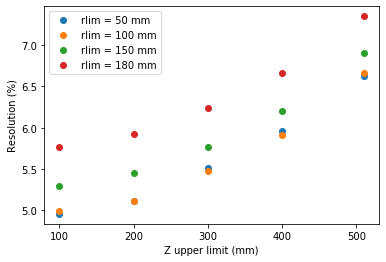

Innermost resolution =  4.96 %
Outermost resolution =  7.35 %
All resolutions: {100050: 4.958317931142651, 100100: 4.9917406636853645, 100150: 5.297420774435461, 100180: 5.763193951568324, 200050: 5.12010259020187, 200100: 5.118534458458912, 200150: 5.452516407882408, 200180: 5.9213327246893535, 300050: 5.512074049312794, 300100: 5.4769175663782566, 300150: 5.770701851587821, 300180: 6.241027307146889, 400050: 5.958340703137787, 400100: 5.9168357525094, 400150: 6.205095267237178, 400180: 6.666238449163845, 510050: 6.629509523327549, 510100: 6.65650333844799, 510150: 6.904462990605891, 510180: 7.347361670178485}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 4658.3 , 9993.1
Selected percentage = 9.9 \%


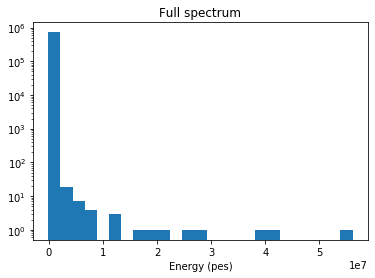

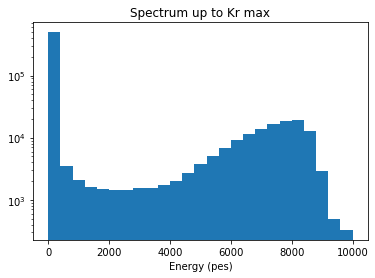

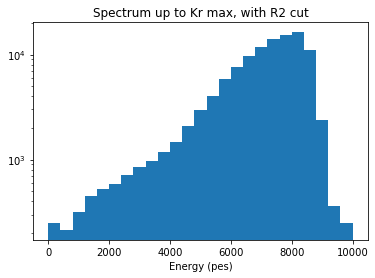

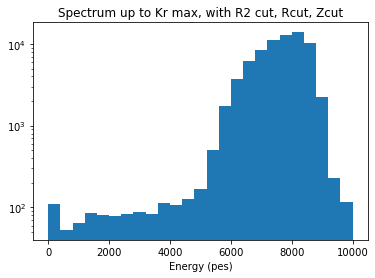

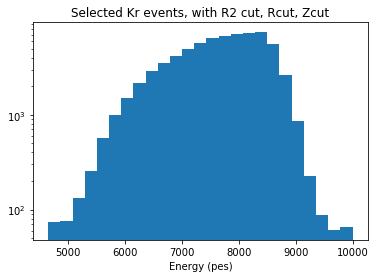

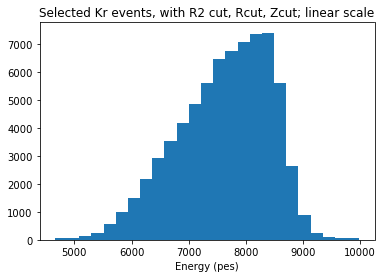

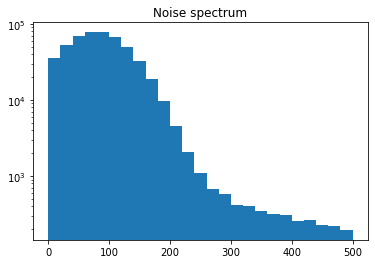

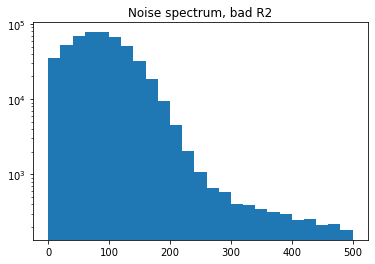

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


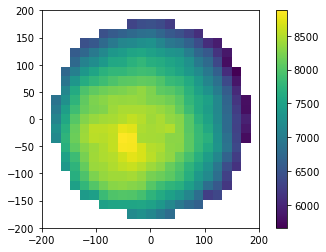

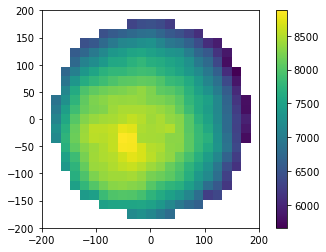

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 12.4
200000 / 612184
Est remaining = 10.1
300000 / 612184
Est remaining = 7.5
400000 / 612184
Est remaining = 5.0
500000 / 612184
Est remaining = 2.7
600000 / 612184
Est remaining = 0.3


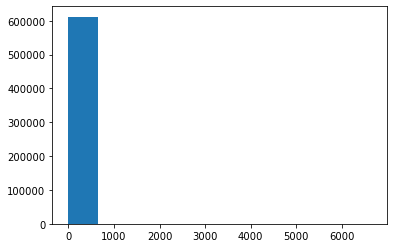

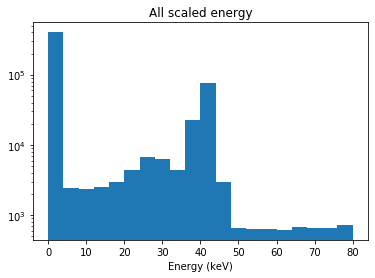

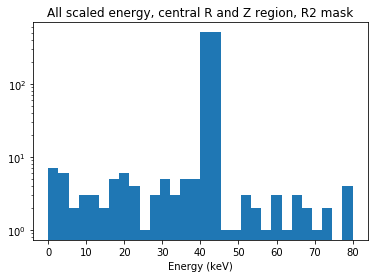

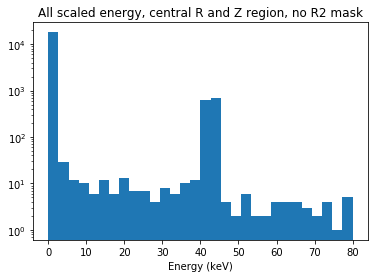

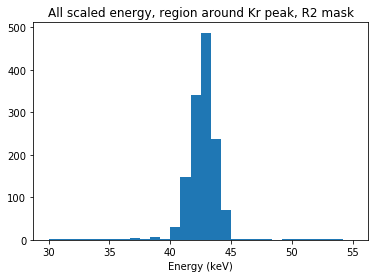

Correcting energies...
0 / 71520


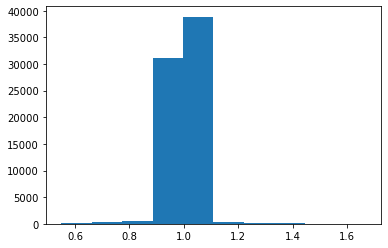

Fit a Gaussian with guess (A0, m0, s0) = (185.0, 1, 0.04211377275630102)


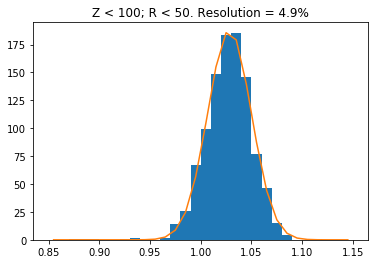

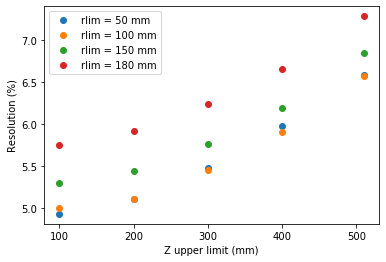

Innermost resolution =  4.93 %
Outermost resolution =  7.28 %
All resolutions: {100050: 4.927418351350997, 100100: 4.992039735864491, 100150: 5.296363435140755, 100180: 5.7427828563332595, 200050: 5.108542114018732, 200100: 5.104150451741402, 200150: 5.442044539227211, 200180: 5.910374322040964, 300050: 5.468788947425191, 300100: 5.452405725636277, 300150: 5.7614638333075945, 300180: 6.238242304296776, 400050: 5.972686041945085, 400100: 5.90116628850183, 400150: 6.192721694727684, 400180: 6.655664671338955, 510050: 6.578189512191581, 510100: 6.572668386463147, 510150: 6.8409848114565195, 510180: 7.278959074356479}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

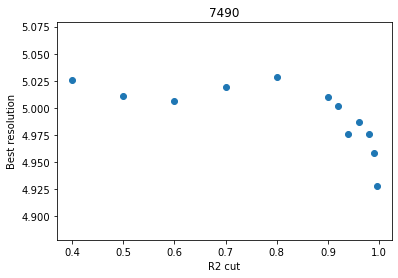

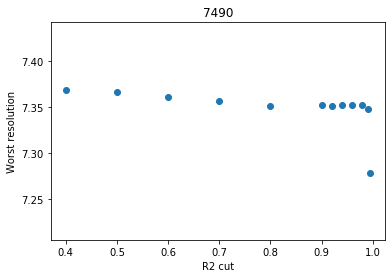

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = 4533.8 , 9993.7
Selected percentage = 10.7 \%


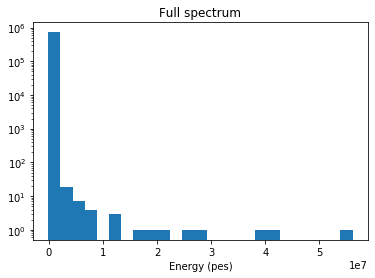

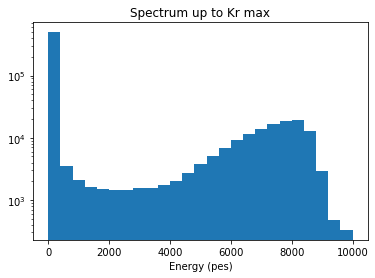

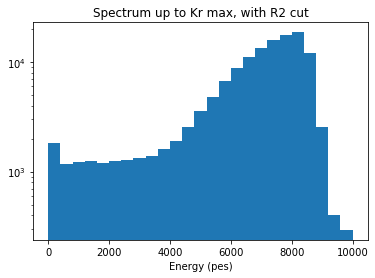

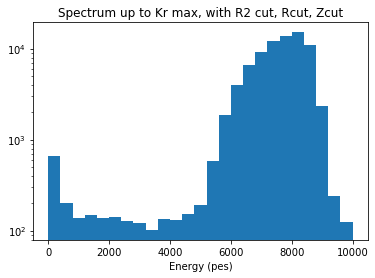

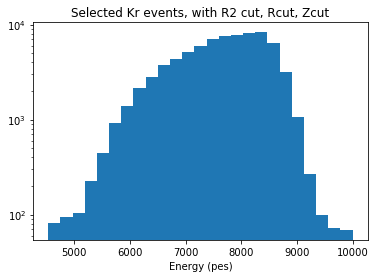

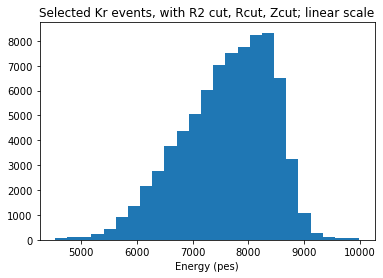

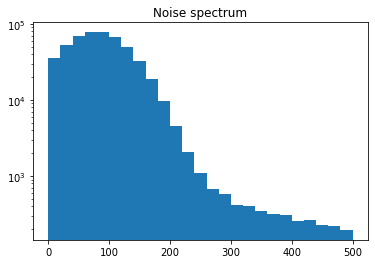

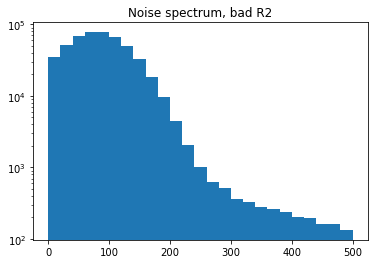

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


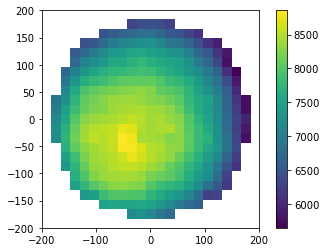

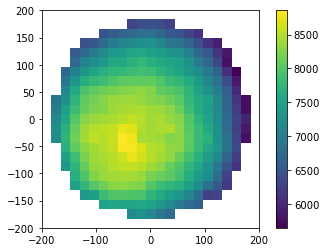

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 9.1
200000 / 612184
Est remaining = 7.6
300000 / 612184
Est remaining = 5.9
400000 / 612184
Est remaining = 4.0
500000 / 612184
Est remaining = 2.1
600000 / 612184
Est remaining = 0.2


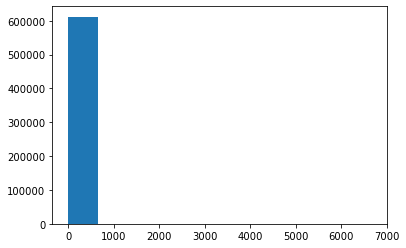

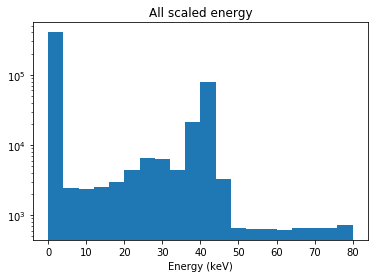

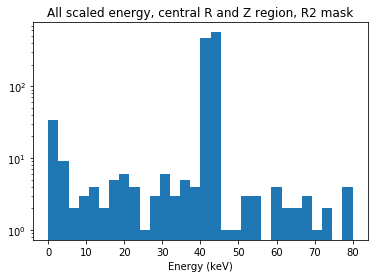

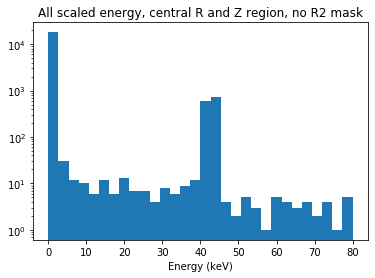

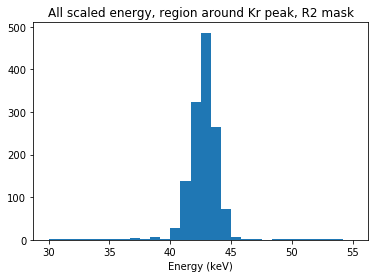

Correcting energies...
0 / 77634


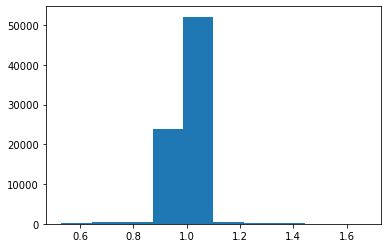

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.045269567741692544)


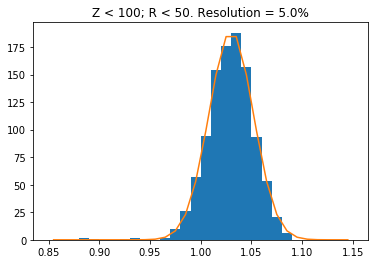

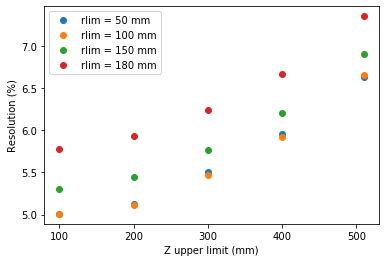

Innermost resolution =  5.01 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.0102724729160215, 100100: 5.007773020213628, 100150: 5.307614626399207, 100180: 5.774323749605739, 200050: 5.119923934861382, 200100: 5.112886298280806, 200150: 5.447667296889177, 200180: 5.928357881414043, 300050: 5.510015235164473, 300100: 5.47209728256366, 300150: 5.76373538952604, 300180: 6.245920302516311, 400050: 5.959735827169621, 400100: 5.916590857199791, 400150: 6.199962776871508, 400180: 6.673000148120859, 510050: 6.628381001108396, 510100: 6.655890472840465, 510150: 6.901548952455954, 510180: 7.352191828043946}
Peak range = 4542.5 , 10024.4
Selected percentage = 10.7 \%


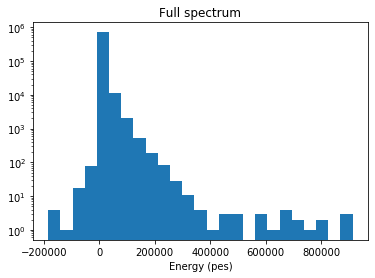

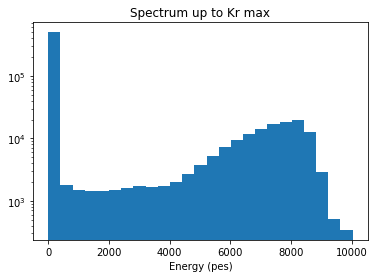

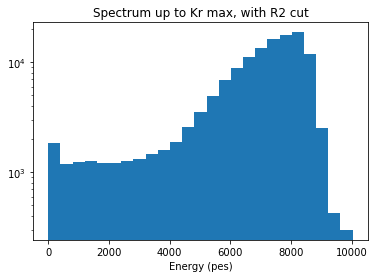

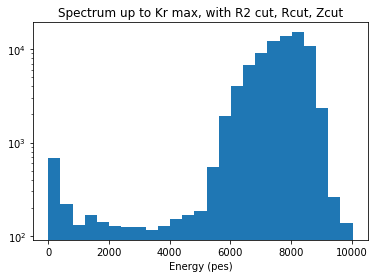

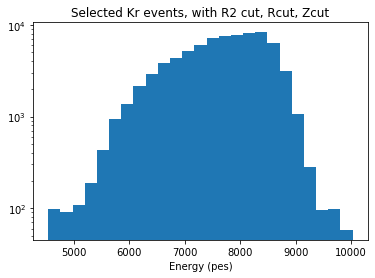

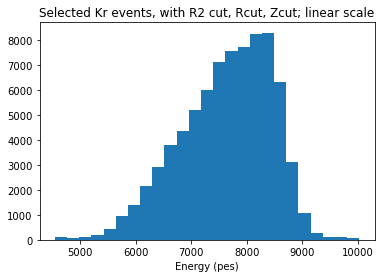

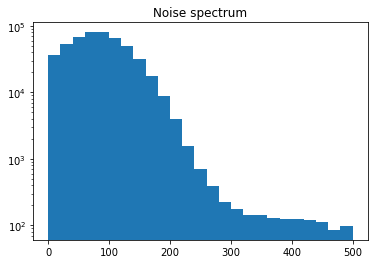

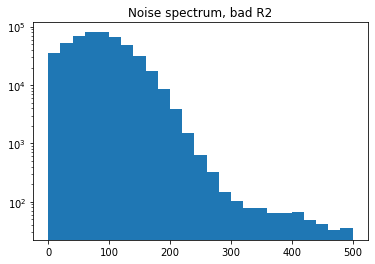

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


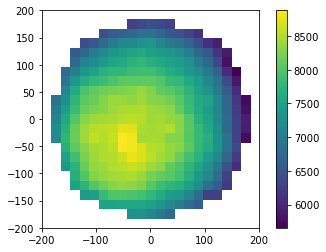

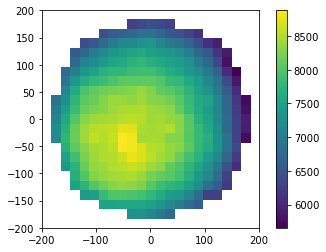

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 7.6
200000 / 612184
Est remaining = 6.5
300000 / 612184
Est remaining = 4.7
400000 / 612184
Est remaining = 3.2
500000 / 612184
Est remaining = 1.7
600000 / 612184
Est remaining = 0.2


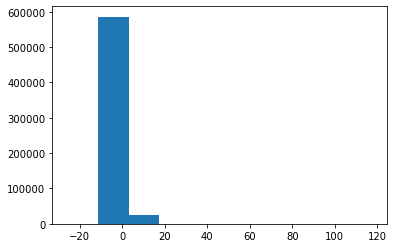

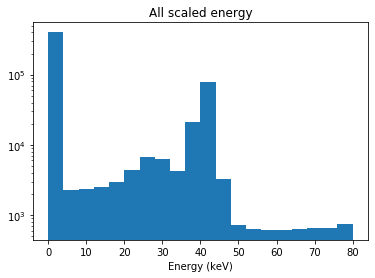

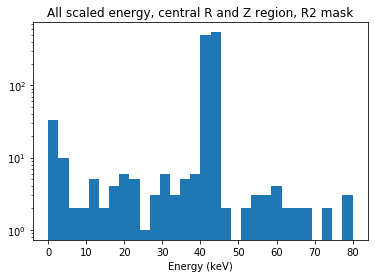

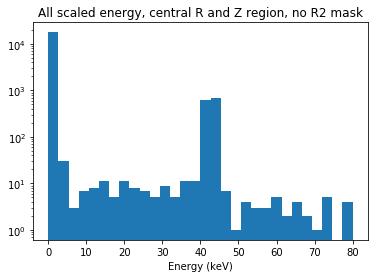

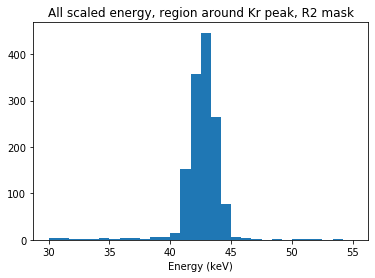

Correcting energies...
0 / 77657


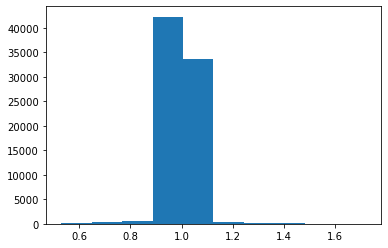

Fit a Gaussian with guess (A0, m0, s0) = (181.0, 1, 0.04503065359222434)


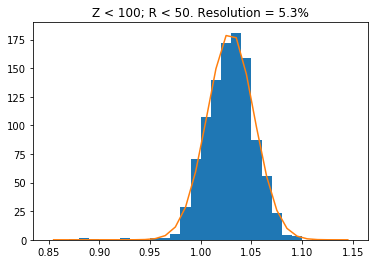

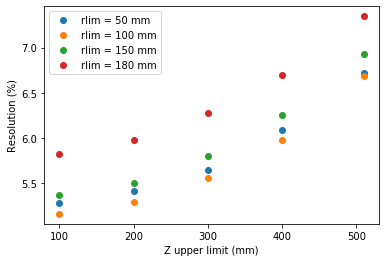

Innermost resolution =  5.27 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.274477453448526, 100100: 5.154604868890097, 100150: 5.36587488586333, 100180: 5.81626216527756, 200050: 5.410626109929805, 200100: 5.286732064649264, 200150: 5.501814022496005, 200180: 5.969605082519614, 300050: 5.644739299511413, 300100: 5.550110668495404, 300150: 5.799578168436451, 300180: 6.271690979101286, 400050: 6.087224131274459, 400100: 5.979123592030303, 400150: 6.247666984415804, 400180: 6.698277491606705, 510050: 6.718559416949308, 510100: 6.68004681287017, 510150: 6.925360564499711, 510180: 7.3484996868408565}
Peak range = 4542.5 , 10024.4
Selected percentage = 10.7 \%


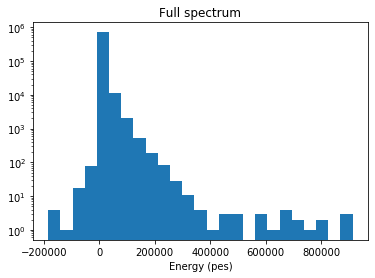

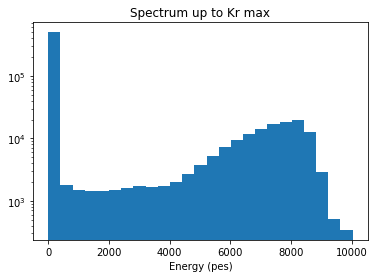

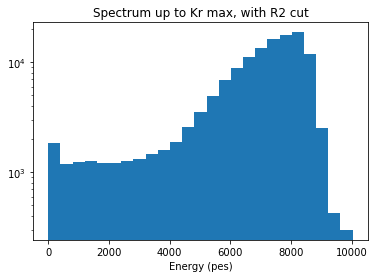

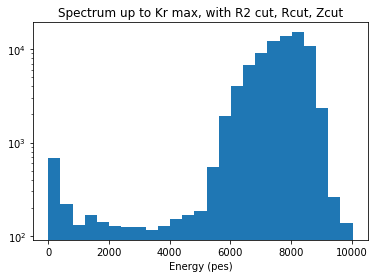

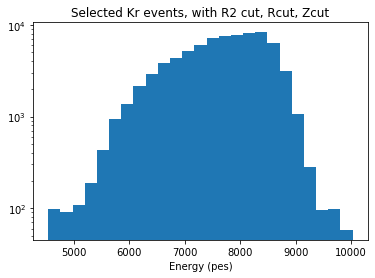

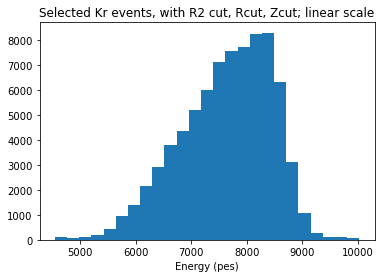

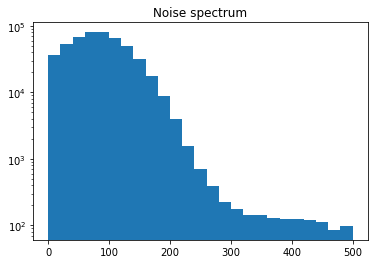

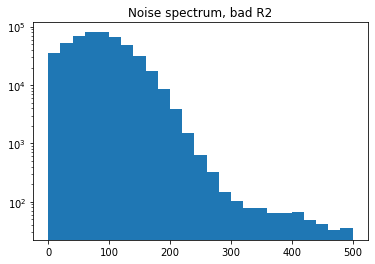

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


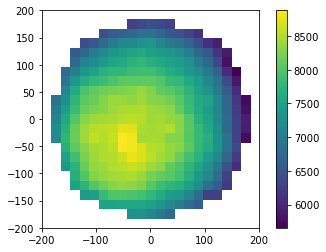

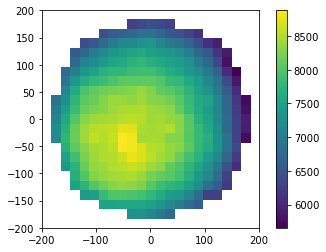

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 6.8
200000 / 612184
Est remaining = 5.7
300000 / 612184
Est remaining = 4.3
400000 / 612184
Est remaining = 2.9
500000 / 612184
Est remaining = 1.5
600000 / 612184
Est remaining = 0.2


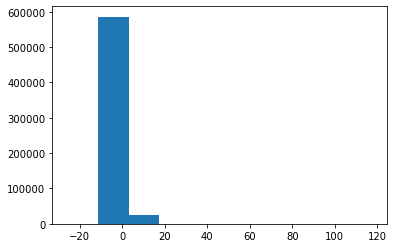

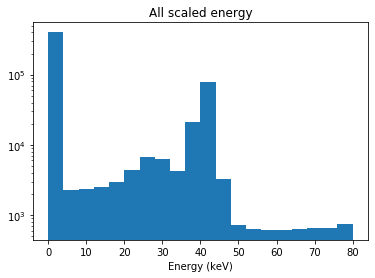

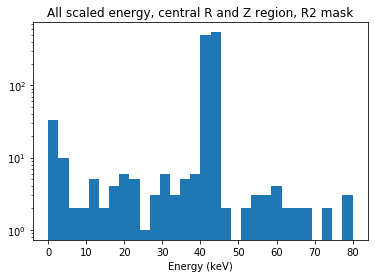

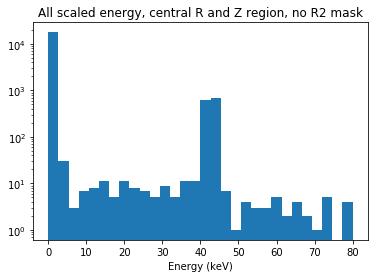

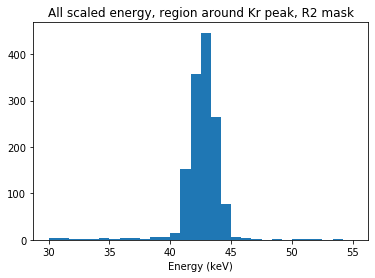

Correcting energies...
0 / 77657


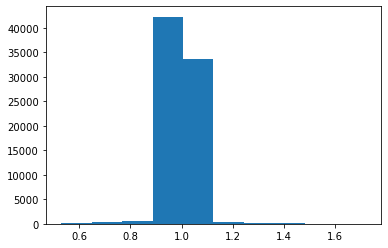

Fit a Gaussian with guess (A0, m0, s0) = (181.0, 1, 0.04503065359222434)


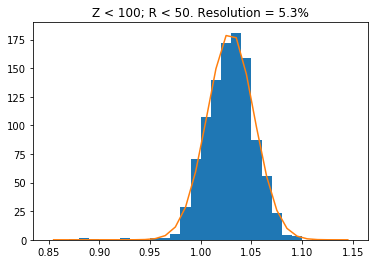

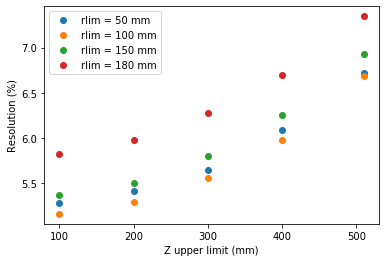

Innermost resolution =  5.27 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.274477453448526, 100100: 5.154604868890097, 100150: 5.36587488586333, 100180: 5.81626216527756, 200050: 5.410626109929805, 200100: 5.286732064649264, 200150: 5.501814022496005, 200180: 5.969605082519614, 300050: 5.644739299511413, 300100: 5.550110668495404, 300150: 5.799578168436451, 300180: 6.271690979101286, 400050: 6.087224131274459, 400100: 5.979123592030303, 400150: 6.247666984415804, 400180: 6.698277491606705, 510050: 6.718559416949308, 510100: 6.68004681287017, 510150: 6.925360564499711, 510180: 7.3484996868408565}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
5.01 , 5.27 , 5.27
Outer res for pre, post, avg:
7.35 , 7.35 , 7.35


Peak range = 4533.8 , 9993.7
Selected percentage = 10.7 \%


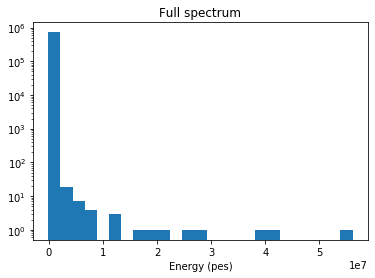

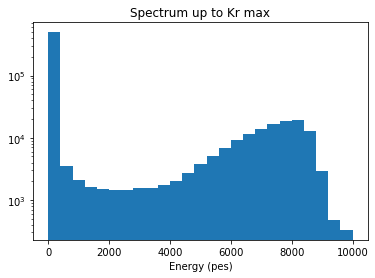

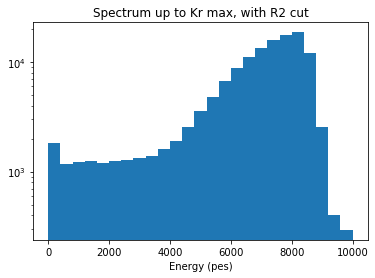

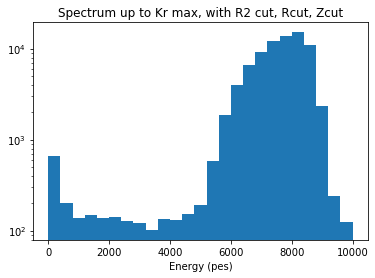

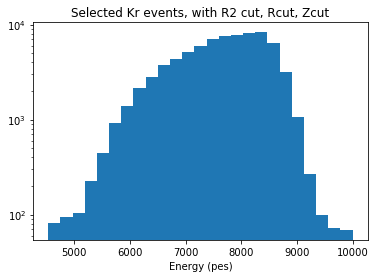

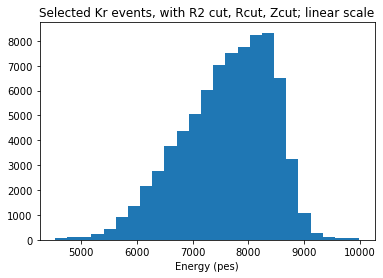

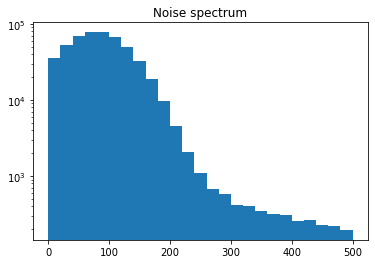

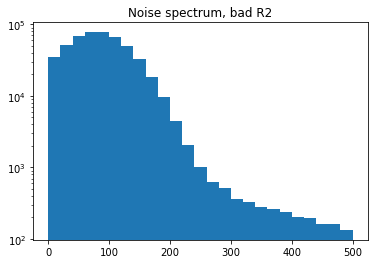

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


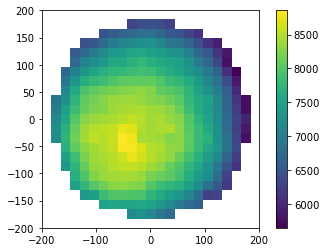

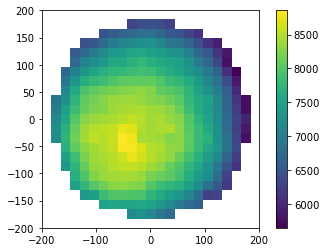

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 7.0
200000 / 612184
Est remaining = 5.8
300000 / 612184
Est remaining = 4.4
400000 / 612184
Est remaining = 3.2
500000 / 612184
Est remaining = 1.7
600000 / 612184
Est remaining = 0.2


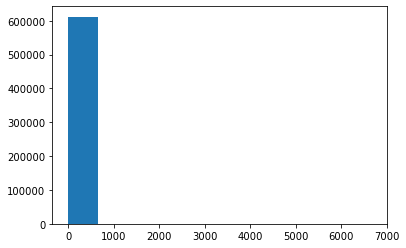

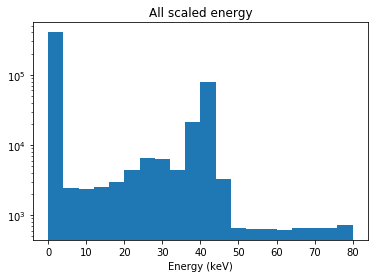

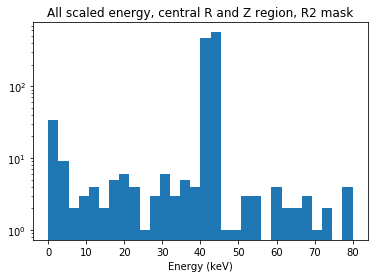

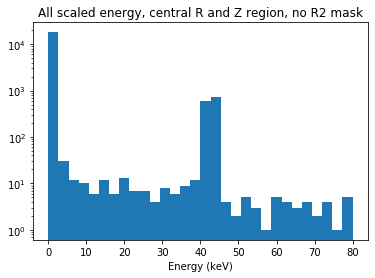

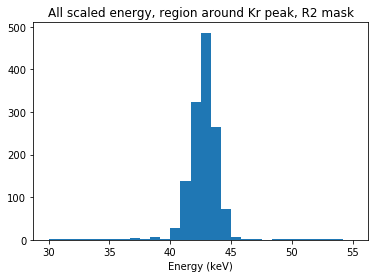

Correcting energies...
0 / 77634


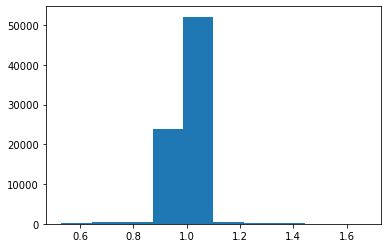

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.045269567741692544)


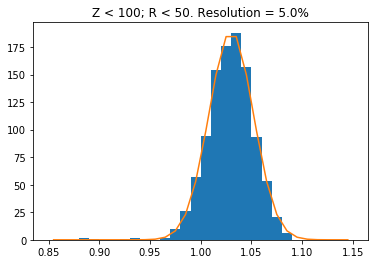

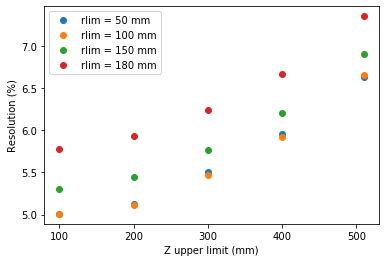

Innermost resolution =  5.01 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.0102724729160215, 100100: 5.007773020213628, 100150: 5.307614626399207, 100180: 5.774323749605739, 200050: 5.119923934861382, 200100: 5.112886298280806, 200150: 5.447667296889177, 200180: 5.928357881414043, 300050: 5.510015235164473, 300100: 5.47209728256366, 300150: 5.76373538952604, 300180: 6.245920302516311, 400050: 5.959735827169621, 400100: 5.916590857199791, 400150: 6.199962776871508, 400180: 6.673000148120859, 510050: 6.628381001108396, 510100: 6.655890472840465, 510150: 6.901548952455954, 510180: 7.352191828043946}
Peak range = 4559.6 , 10001.6
Selected percentage = 10.3 \%


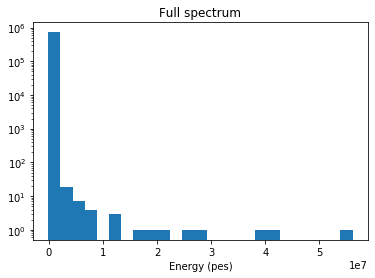

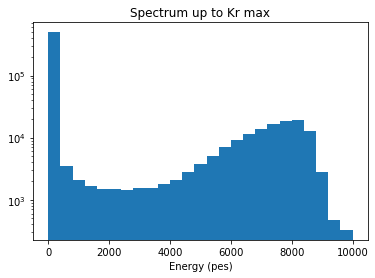

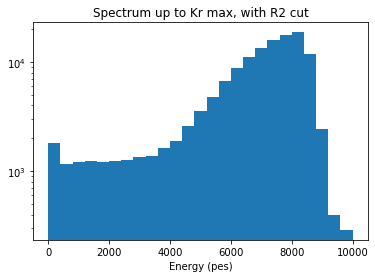

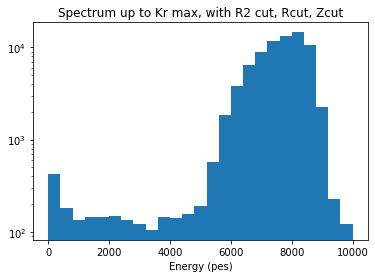

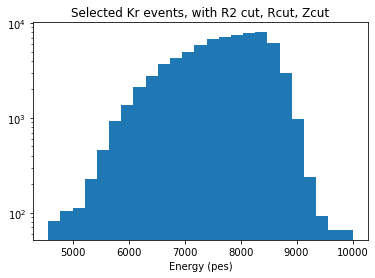

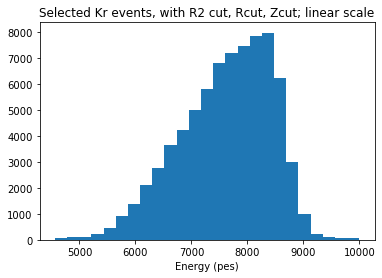

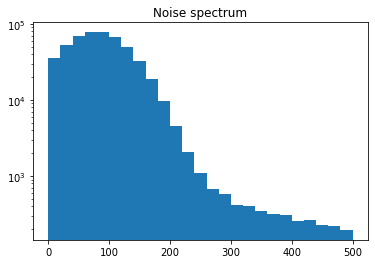

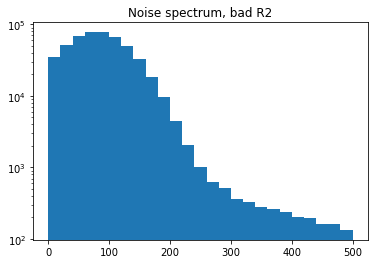

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


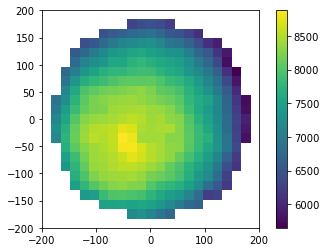

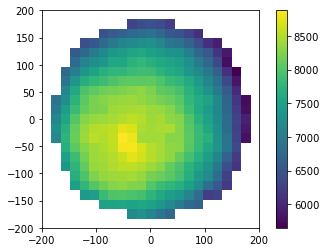

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 7.3
200000 / 612184
Est remaining = 6.0
300000 / 612184
Est remaining = 4.6
400000 / 612184
Est remaining = 3.1
500000 / 612184
Est remaining = 1.6
600000 / 612184
Est remaining = 0.2


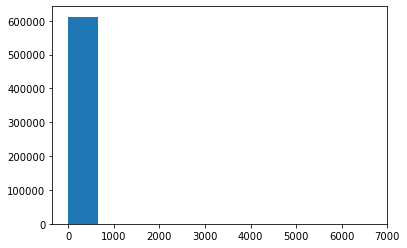

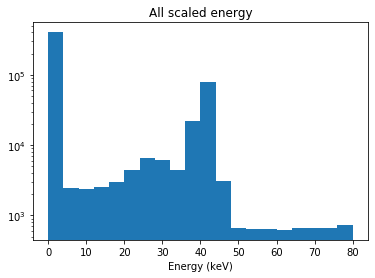

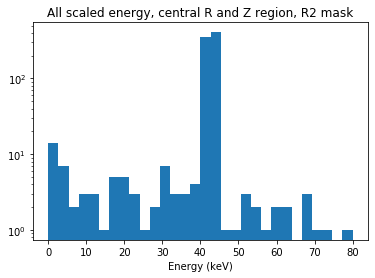

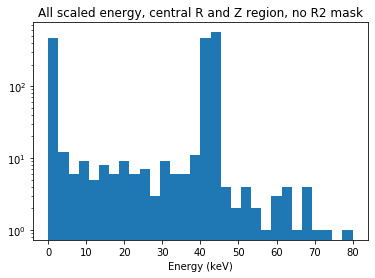

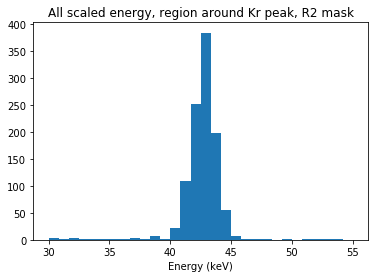

Correcting energies...
0 / 74951


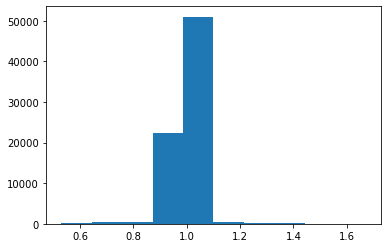

Fit a Gaussian with guess (A0, m0, s0) = (148.0, 1, 0.048649137470165416)


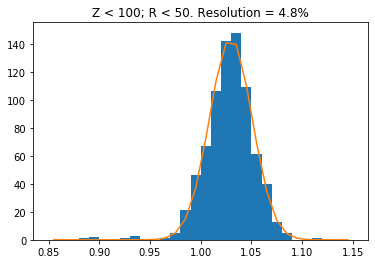

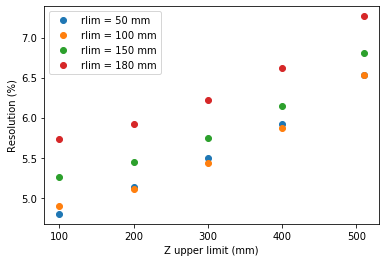

Innermost resolution =  4.8 %
Outermost resolution =  7.27 %
All resolutions: {100050: 4.797324562616098, 100100: 4.901760392402941, 100150: 5.259286391668107, 100180: 5.736952100371315, 200050: 5.1308382662009615, 200100: 5.106673165512168, 200150: 5.445497109835507, 200180: 5.917617593414195, 300050: 5.49632380182968, 300100: 5.434166280683617, 300150: 5.742515697892001, 300180: 6.218440150766031, 400050: 5.92544209268187, 400100: 5.87519020497408, 400150: 6.151033812751073, 400180: 6.619205156047234, 510050: 6.537714644953723, 510100: 6.534581737375219, 510150: 6.8139607214958255, 510180: 7.267122863684121}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
4.8 , 5.01
Outer res for rms, gauss:
7.27 , 7.35


Peak range = 4533.8 , 9993.7
Selected percentage = 10.7 \%


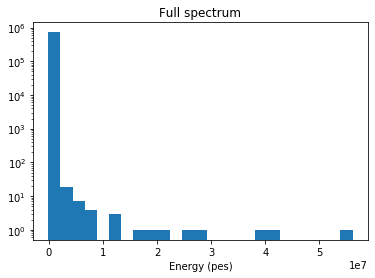

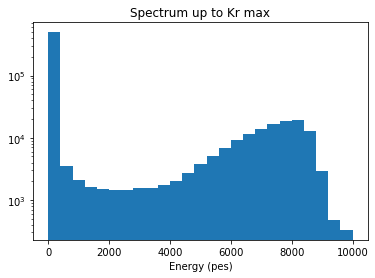

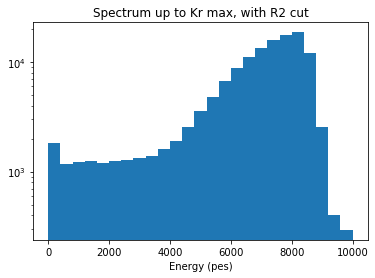

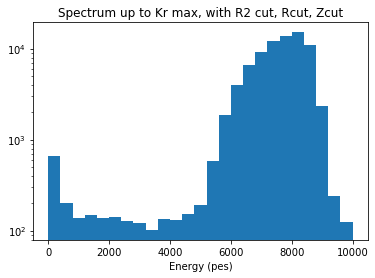

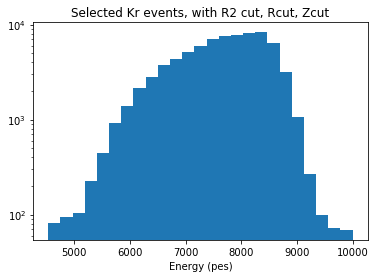

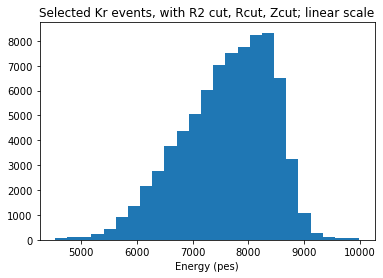

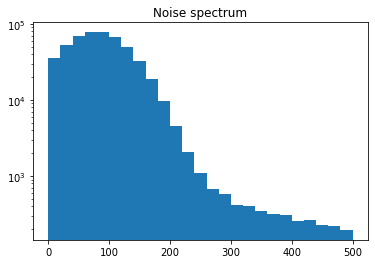

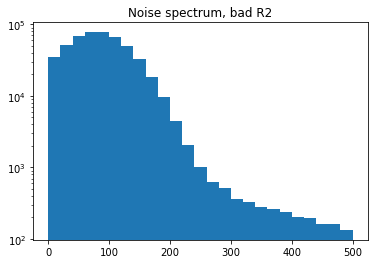

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


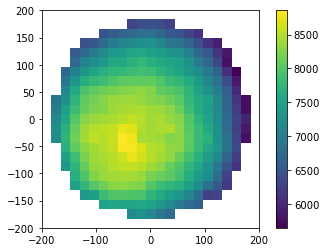

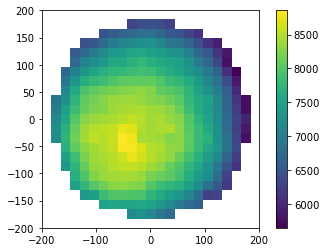

Correcting energies...
0 / 612184
100000 / 612184
Est remaining = 5.0
200000 / 612184
Est remaining = 4.0
300000 / 612184
Est remaining = 2.9
400000 / 612184
Est remaining = 2.0
500000 / 612184
Est remaining = 1.0
600000 / 612184
Est remaining = 0.1


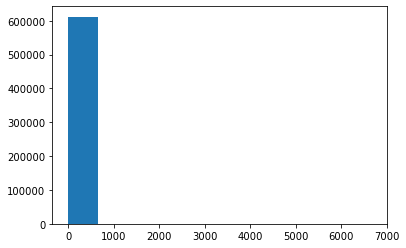

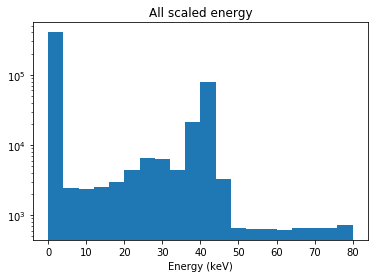

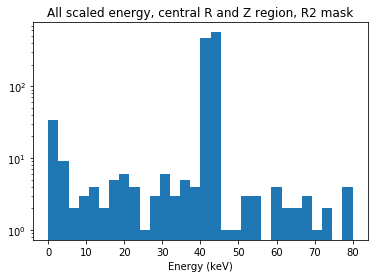

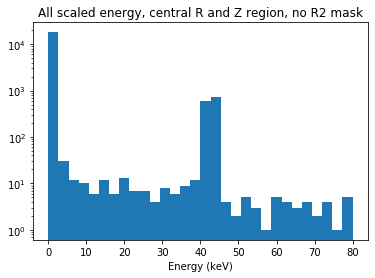

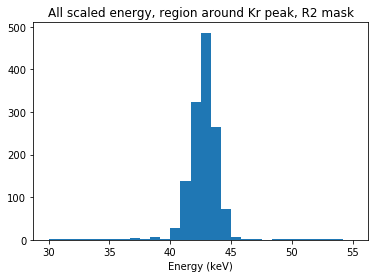

Correcting energies...
0 / 77634


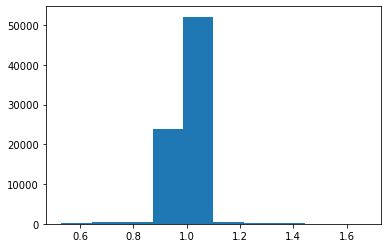

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.045269567741692544)


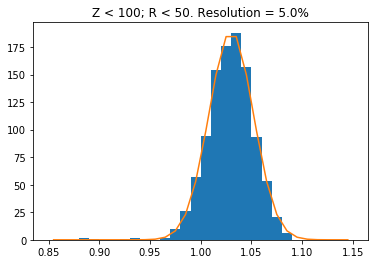

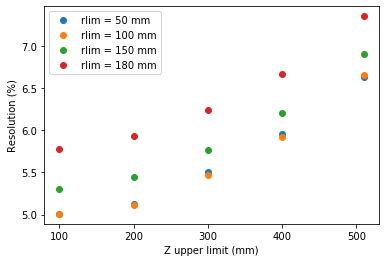

Innermost resolution =  5.01 %
Outermost resolution =  7.35 %
All resolutions: {100050: 5.0102724729160215, 100100: 5.007773020213628, 100150: 5.307614626399207, 100180: 5.774323749605739, 200050: 5.119923934861382, 200100: 5.112886298280806, 200150: 5.447667296889177, 200180: 5.928357881414043, 300050: 5.510015235164473, 300100: 5.47209728256366, 300150: 5.76373538952604, 300180: 6.245920302516311, 400050: 5.959735827169621, 400100: 5.916590857199791, 400150: 6.199962776871508, 400180: 6.673000148120859, 510050: 6.628381001108396, 510100: 6.655890472840465, 510150: 6.901548952455954, 510180: 7.352191828043946}


{100050: 5.0102724729160215,
 100100: 5.007773020213628,
 100150: 5.307614626399207,
 100180: 5.774323749605739,
 200050: 5.119923934861382,
 200100: 5.112886298280806,
 200150: 5.447667296889177,
 200180: 5.928357881414043,
 300050: 5.510015235164473,
 300100: 5.47209728256366,
 300150: 5.76373538952604,
 300180: 6.245920302516311,
 400050: 5.959735827169621,
 400100: 5.916590857199791,
 400150: 6.199962776871508,
 400180: 6.673000148120859,
 510050: 6.628381001108396,
 510100: 6.655890472840465,
 510150: 6.901548952455954,
 510180: 7.352191828043946}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 18.5 minutes
